<a href="https://colab.research.google.com/github/Faskill/MLOps-Project-Classification/blob/main/Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Applying MLOPS principles to develop an Article Classification Model

Last updated : 6th January 2023

## Introduction

The goal of this project is to develop a Project Classification Model using production grade MLOPS practices. 

In this notebook, I will develop a supervised machine learning (classification) model using a simple vectorization algorithm (TF-IDF).

This model could be improved by using BERT Embeddings and a higher-end deep learning model.

After developing this baseline model, I will optimize it using experiment tracking modules before switching to Python scripts for the development and deployment of more advanced alternatives.

## 1. Data Loading and Analysis

### 1.1 ETL

In [ ]:
import pandas as pd
# Loading projects"
projects = pd.read_csv("projects.csv")
projects.head(5)

,id,created_on,title,description
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla..."
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...
4,19,2020-03-03 13:54:31,Diffusion to Vector,Reference implementation of Diffusion2Vec (Com...


In [ ]:
# Loading tags
tags = pd.read_csv("tags.csv")
tags.head(5)

,id,tag
0,6,computer-vision
1,7,computer-vision
2,9,graph-learning
3,15,reinforcement-learning
4,19,graph-learning


In [ ]:
# Merging projects and tags
df = pd.merge(projects, tags, on="id", how = "outer")
df.head()

,id,created_on,title,description,tag
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...,computer-vision
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...,computer-vision
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla...",graph-learning
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,reinforcement-learning
4,19,2020-03-03 13:54:31,Diffusion to Vector,Reference implementation of Diffusion2Vec (Com...,graph-learning


In [ ]:
# Removing projects without a tag
df = df[df.tag.notnull()]
df.head()

,id,created_on,title,description,tag
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...,computer-vision
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...,computer-vision
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla...",graph-learning
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,reinforcement-learning
4,19,2020-03-03 13:54:31,Diffusion to Vector,Reference implementation of Diffusion2Vec (Com...,graph-learning


In [ ]:
# Saving data locally
df.to_csv("labeled_projects.csv", index=False)

### 1.2 Exploratory Data Analysis (EDA)

In [ ]:
# Counting the number of tags of each category
df.tag.value_counts()

natural-language-processing    388
computer-vision                356
mlops                           79
reinforcement-learning          56
graph-learning                  45
time-series                     31
Name: tag, dtype: int64

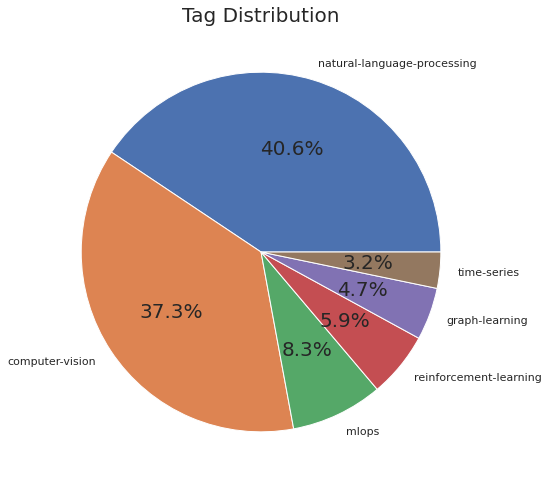

In [ ]:
#Creating a pie chart of the tags
import matplotlib.pyplot as plt
import seaborn as sns
#Setting large figure size for Seaborn
sns.set(rc={'figure.figsize':(11.7,8.27),"font.size":20,"axes.titlesize":20,"axes.labelsize":18})

vc = df.tag.value_counts()
plt.pie(vc, labels = vc.index,autopct='%1.1f%%')
plt.title('Tag Distribution')
plt.show()

In [ ]:
# Calculating title and description length
df['title_length'] = df['title'].apply(len)
df['desc_length'] = df['description'].apply(len)

df.head()

,id,created_on,title,description,tag,title_length,desc_length
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...,computer-vision,53,107
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...,computer-vision,64,147
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla...",graph-learning,28,114
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,reinforcement-learning,31,71
4,19,2020-03-03 13:54:31,Diffusion to Vector,Reference implementation of Diffusion2Vec (Com...,graph-learning,19,89


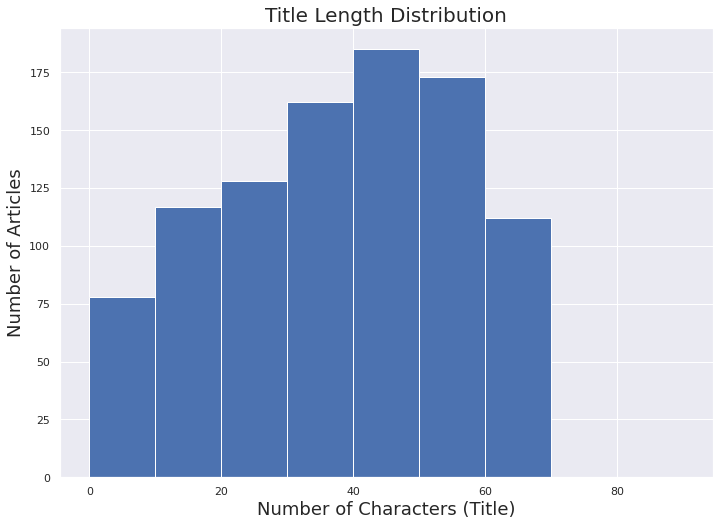

In [ ]:
#Histogram of title length
plt.hist(df['title_length'], bins = range(0,100,10))
plt.title('Title Length Distribution')
plt.xlabel('Number of Characters (Title)')
plt.ylabel('Number of Articles')
plt.show()

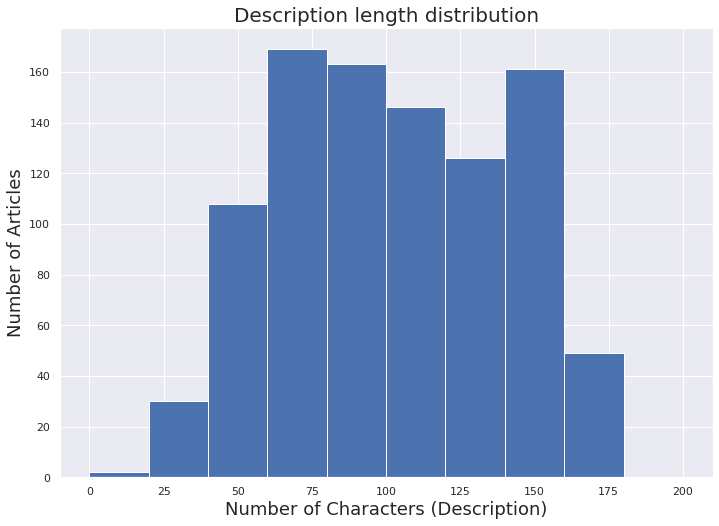

In [ ]:
#Histogram of description length
plt.hist(df['desc_length'], bins = range(0,220,20))
plt.title('Description length distribution')
plt.xlabel('Number of Characters (Description)')
plt.ylabel('Number of Articles')
plt.show()

In [ ]:
#Let's investigate the outliers with a description below 25 characters
df[df.desc_length < 25]

,id,created_on,title,description,tag,title_length,desc_length
29,108,2020-03-21 23:17:38,Tuned ALBERT (ensemble model),Top 6 in Squad 2.0,natural-language-processing,29,18
341,880,2020-05-16 11:50:31,How Deep Is Your Love For Transfer Learning In...,A review of NLP research,natural-language-processing,51,24
536,1480,2020-06-16 23:06:13,A Guide to Natural Language Processing With Al...,basics of using AllenNLP,natural-language-processing,52,24
695,1856,2020-07-14 03:21:00,DeepDream Video Style Transfer,DeepDream on Video,computer-vision,30,18
737,1934,2020-07-21 01:47:01,Graphein,Protein Graph Library,graph-learning,8,21
747,1954,2020-07-24 06:43:59,Azure ML,MLOps using Azure ML.,mlops,8,21
942,2417,2020-10-02 09:44:25,Parallelizing Prophet Cross-Validation with Dask,Applied Example w/ Code,time-series,48,23


It seems like most projects with short description are pretty easy to classify because they have keywords either in the title or in the description, so we won't remove them from our database.

In [ ]:
df['tag'].unique()

array(['computer-vision', 'graph-learning', 'reinforcement-learning',
       'natural-language-processing', 'mlops', 'time-series'],
      dtype=object)

In [ ]:
# Looking at important words for each tags
from wordcloud import WordCloud, STOPWORDS
import ipywidgets as widgets

# Most frequent tokens for each tag
@widgets.interact(tag=df['tag'].unique())
def display_word_cloud(tag="natural-language-processing"):
    # Plot word clouds top top tags
    plt.figure(figsize=(15, 5))
    subset = df[df.tag==tag]
    text = subset.title.values
    cloud = WordCloud(
        stopwords=STOPWORDS, background_color="black", collocations=False,
        width=500, height=300).generate(" ".join(text))
    plt.axis("off")
    plt.imshow(cloud)
    plt.show()

interactive(children=(Dropdown(description='tag', index=3, options=('computer-vision', 'graph-learning', 'rein…

## 2. Data Preprocessing

### 2.1 Feature engineering

The feature engineering process will be very short in that case because we're only going to analyze text data in that case.

In [ ]:
# Merging all text data
df['text'] = df['title'] + ' ' + df['description']
df.head()

,id,created_on,title,description,tag,title_length,desc_length,text
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...,computer-vision,53,107,Comparison between YOLO and RCNN on real world...
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...,computer-vision,64,147,"Show, Infer & Tell: Contextual Inference for C..."
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla...",graph-learning,28,114,Awesome Graph Classification A collection of i...
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,reinforcement-learning,31,71,Awesome Monte Carlo Tree Search A curated list...
4,19,2020-03-03 13:54:31,Diffusion to Vector,Reference implementation of Diffusion2Vec (Com...,graph-learning,19,89,Diffusion to Vector Reference implementation o...


### 2.1 Text Data Preprocessing

First we will preprocess our text data. In line with the goal of this project, which is to create a quick version of our model, we will use nltk to be able to use stemming if necessary. 

In a production environment, a good (and quicker) alternative would be SpaCy to be able to use lemmatization.

In [ ]:
!pip install nltk==3.7 -q
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

In [ ]:
nltk.download("stopwords")
STOPWORDS = stopwords.words("english")
stemmer = PorterStemmer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Creating a function to preprocess text data
def clean_text(text, lower=True, stem=False, stopwords=STOPWORDS):
    """Clean raw text."""
    # Lower
    if lower:
        text = text.lower()

    # Remove stopwords
    if len(stopwords):
        pattern = re.compile(r'\b(' + r"|".join(stopwords) + r")\b\s*")
        text = pattern.sub('', text)

    # Spacing and filters
    text = re.sub(
        r"([!\"'#$%&()*\+,-./:;<=>?@\\\[\]^_`{|}~])", r" \1 ", text
    )  # add spacing between objects to be filtered
    text = re.sub("[^A-Za-z0-9]+", " ", text)  # remove non alphanumeric chars
    text = re.sub(" +", " ", text)  # remove multiple spaces
    text = text.strip()  # strip white space at the ends

    # Remove links
    text = re.sub(r"http\S+", "", text)

    # Stemming
    if stem:
        text = " ".join([stemmer.stem(word, to_lowercase=lower) for word in text.split(" ")])

    return text

In [ ]:
# Apply to dataframe
df['cleaned_text'] = df.text.apply(clean_text, lower=True, stem=False)
print (f"{df.text.values[0]}\n{df.cleaned_text.values[0]}")

Comparison between YOLO and RCNN on real world videos Bringing theory to experiment is cool. We can easily train models in colab and find the results in minutes.
comparison yolo rcnn real world videos bringing theory experiment cool easily train models colab find results minutes


### 2.2 Handling out of scope (OOS) tags

Since we are using a data set with a limited sample size, we will replace tags with too few samples with a "other" category.

In [ ]:
import json
#List of accepted tags (external constraint)
ACCEPTED_TAGS = ["natural-language-processing", "computer-vision", "mlops", "graph-learning"]

#Out of scope (OOS) tags
oos_tags = [item for item in df.tag.unique() if item not in ACCEPTED_TAGS]
oos_tags

['reinforcement-learning', 'time-series']

In [ ]:
# Samples with OOS tags
oos_indices = df[df.tag.isin(oos_tags)].index
df[df.tag.isin(oos_tags)].head()

,id,created_on,title,description,tag,title_length,desc_length,text,cleaned_text
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,reinforcement-learning,31,71,Awesome Monte Carlo Tree Search A curated list...,awesome monte carlo tree search curated list m...
37,121,2020-03-24 04:56:38,Deep Reinforcement Learning in TensorFlow2,deep-rl-tf2 is a repository that implements a ...,reinforcement-learning,42,147,Deep Reinforcement Learning in TensorFlow2 dee...,deep reinforcement learning tensorflow2 deep r...
67,218,2020-04-06 11:29:57,Distributional RL using TensorFlow2,🐳 Implementation of various Distributional Rei...,reinforcement-learning,35,95,Distributional RL using TensorFlow2 🐳 Implemen...,distributional rl using tensorflow2 implementa...
74,239,2020-04-06 18:39:48,Prophet: Forecasting At Scale,Tool for producing high quality forecasts for ...,time-series,29,126,Prophet: Forecasting At Scale Tool for produci...,prophet forecasting scale tool producing high ...
95,277,2020-04-07 00:30:33,Curriculum for Reinforcement Learning,Curriculum learning applied to reinforcement l...,reinforcement-learning,37,100,Curriculum for Reinforcement Learning Curricul...,curriculum reinforcement learning curriculum l...


In [ ]:
# Replacing this tag with "other"
df.tag = df.tag.apply(lambda x: "other" if x in oos_tags else x)
df.iloc[oos_indices].head()

,id,created_on,title,description,tag,title_length,desc_length,text,cleaned_text
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,other,31,71,Awesome Monte Carlo Tree Search A curated list...,awesome monte carlo tree search curated list m...
37,121,2020-03-24 04:56:38,Deep Reinforcement Learning in TensorFlow2,deep-rl-tf2 is a repository that implements a ...,other,42,147,Deep Reinforcement Learning in TensorFlow2 dee...,deep reinforcement learning tensorflow2 deep r...
67,218,2020-04-06 11:29:57,Distributional RL using TensorFlow2,🐳 Implementation of various Distributional Rei...,other,35,95,Distributional RL using TensorFlow2 🐳 Implemen...,distributional rl using tensorflow2 implementa...
74,239,2020-04-06 18:39:48,Prophet: Forecasting At Scale,Tool for producing high quality forecasts for ...,other,29,126,Prophet: Forecasting At Scale Tool for produci...,prophet forecasting scale tool producing high ...
95,277,2020-04-07 00:30:33,Curriculum for Reinforcement Learning,Curriculum learning applied to reinforcement l...,other,37,100,Curriculum for Reinforcement Learning Curricul...,curriculum reinforcement learning curriculum l...


In [ ]:
df.tag.value_counts()

natural-language-processing    388
computer-vision                356
other                           87
mlops                           79
graph-learning                  45
Name: tag, dtype: int64

In [ ]:
#Not enough data to identify the graph learning topics (we set a threshold at 75)
#We will join this category with our "other" category
def filter_tags(tag, exclude=[]):
  if tag in exclude:
    tag = None
  return tag

df.tag = df.tag.apply(filter_tags, exclude = ['graph-learning'])

df.tag = df.tag.fillna("other")
df.tag.value_counts()

natural-language-processing    388
computer-vision                356
other                          132
mlops                           79
Name: tag, dtype: int64

In [ ]:
import numpy as np
import random


# Get data
X = df.cleaned_text.to_numpy()
y = df.tag

### 2.3 Categorical Data Encoding

In this part, we will define our own label encoding function as an example that can be customized to our needs. 

A quicker alternative would be to monkey-patch sklearn's native function.

In [ ]:
#Defining custom LabelEncoder

class LabelEncoder(object):
    """Encode labels into unique indices"""
    def __init__(self, class_to_index={}):
        self.class_to_index = class_to_index or {}  # mutable defaults ;)
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}
        self.classes = list(self.class_to_index.keys())

    def __len__(self):
        return len(self.class_to_index)

    def __str__(self):
        return f"<LabelEncoder(num_classes={len(self)})>"

    def fit(self, y):
        classes = np.unique(y)
        for i, class_ in enumerate(classes):
            self.class_to_index[class_] = i
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}
        self.classes = list(self.class_to_index.keys())
        return self

    def encode(self, y):
        encoded = np.zeros((len(y)), dtype=int)
        for i, item in enumerate(y):
            encoded[i] = self.class_to_index[item]
        return encoded

    def decode(self, y):
        classes = []
        for i, item in enumerate(y):
            classes.append(self.index_to_class[item])
        return classes

    def save(self, fp):
        with open(fp, "w") as fp:
            contents = {"class_to_index": self.class_to_index}
            json.dump(contents, fp, indent=4, sort_keys=False)

    @classmethod
    def load(cls, fp):
        with open(fp, "r") as fp:
            kwargs = json.load(fp=fp)
        return cls(**kwargs)

In [ ]:
# Encoding
label_encoder = LabelEncoder()
label_encoder.fit(y)
num_classes = len(label_encoder)

num_classes

4

In [ ]:
label_encoder.class_to_index

{'computer-vision': 0,
 'mlops': 1,
 'natural-language-processing': 2,
 'other': 3}

In [ ]:
label_encoder.index_to_class

{0: 'computer-vision',
 1: 'mlops',
 2: 'natural-language-processing',
 3: 'other'}

In [ ]:
#Testing encoder
label_encoder.encode(["computer-vision", "mlops", "mlops"])

array([0, 1, 1])

In [ ]:
# Decode
label_encoder.decode(np.array([0, 1, 1]))

['computer-vision', 'mlops', 'mlops']

In [ ]:
# Encode all our labels
y = label_encoder.encode(y)
print (y.shape)

(955,)


In [ ]:
from sklearn.model_selection import train_test_split
# Split sizes
train_size = 0.7
val_size = 0.15
test_size = 0.15

In [ ]:
# Creating train/test split
X_train, X_, y_train, y_ = train_test_split(
    X, y, train_size=train_size, stratify=y)

print (f"train: {len(X_train)} ({(len(X_train) / len(X)):.2f})\n"
       f"remaining: {len(X_)} ({(len(X_) / len(X)):.2f})")

train: 668 (0.70)
remaining: 287 (0.30)


In [ ]:
# Creating test/val split
X_val, X_test, y_val, y_test = train_test_split(
    X_, y_, train_size=0.5, stratify=y_)

print(f"train: {len(X_train)} ({len(X_train)/len(X):.2f})\n"
      f"val: {len(X_val)} ({len(X_val)/len(X):.2f})\n"
      f"test: {len(X_test)} ({len(X_test)/len(X):.2f})")

train: 668 (0.70)
val: 143 (0.15)
test: 144 (0.15)


In [ ]:
# Retrieving counts for each class
counts = {}
counts["train_counts"] = {tag: label_encoder.decode(y_train).count(tag) for tag in label_encoder.classes}
counts["val_counts"] = {tag: label_encoder.decode(y_val).count(tag) for tag in label_encoder.classes}
counts["test_counts"] = {tag: label_encoder.decode(y_test).count(tag) for tag in label_encoder.classes}

# View distributions
pd.DataFrame({
    "train": counts["train_counts"],
    "val": counts["val_counts"],
    "test": counts["test_counts"]
}).T.fillna(0)

,computer-vision,mlops,natural-language-processing,other
train,249,55,272,92
val,53,12,58,20
test,54,12,58,20


In [ ]:
# Adjusting counts across splits
for k in counts["val_counts"].keys():
    counts["val_counts"][k] = int(counts["val_counts"][k] * \
        (train_size/val_size))
for k in counts["test_counts"].keys():
    counts["test_counts"][k] = int(counts["test_counts"][k] * \
        (train_size/test_size))
  
dist_df = pd.DataFrame({
    "train": counts["train_counts"],
    "val": counts["val_counts"],
    "test": counts["test_counts"]
}).T.fillna(0)
dist_df

,computer-vision,mlops,natural-language-processing,other
train,249,55,272,92
val,247,56,270,93
test,252,56,270,93


We can see that our test/train split are quite balanced.
Let's calculate the standard deviation :

In [ ]:
# Standard deviation
np.mean(np.std(dist_df.to_numpy(), axis=0))

0.9851056877051131

This deviation is moderate, which means that there is some imbalance in our classes.

In [ ]:
# Example of code for multi-label classification
!pip install scikit-multilearn
from skmultilearn.model_selection import IterativeStratification
def iterative_train_test_split(X, y, train_size):
    """Custom iterative train test split which
    'maintains balanced representation with respect
    to order-th label combinations.'
    """
    stratifier = IterativeStratification(
        n_splits=2, order=1, sample_distribution_per_fold=[1.0-train_size, train_size, ])
    train_indices, test_indices = next(stratifier.split(X, y))
    X_train, y_train = X[train_indices], y[train_indices]
    X_test, y_test = X[test_indices], y[test_indices]
    return X_train, X_test, y_train, y_test

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 KB 4.0 MB/s eta 0:00:00


In [ ]:
# Creating split DataFrames
train_df = pd.DataFrame({"text": X_train, "tag": label_encoder.decode(y_train)})
val_df = pd.DataFrame({"text": X_val, "tag": label_encoder.decode(y_val)})
test_df = pd.DataFrame({"text": X_test, "tag": label_encoder.decode(y_test)})
train_df.head()

,text,tag
0,nature scene classification using fastai class...,computer-vision
1,illustrated self attention step step guide sel...,natural-language-processing
2,neural networks nlp cmu cs 11 747 class start ...,natural-language-processing
3,building simple chatbot scratch python using n...,natural-language-processing
4,barebones image retrieval system project prese...,computer-vision


### 2.4 Data Augmentation

In this part, we will implement a data augmentation policy for text data.

In [ ]:
# Loagind nlpaug and snorkel

!pip install nlpaug==1.1.0 transformers==3.0.2 -q
!pip install snorkel==0.9.8 -q

import nlpaug.augmenter.word as naw

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.6/380.6 KB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 769.0/769.0 KB 33.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 59.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 79.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 KB 57.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 KB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 33.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.9/24.9 MB 53.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 51.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 37.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.9/152.9 KB 15.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all th

In [ ]:
# Loading tokenizers and transformers
substitution = naw.ContextualWordEmbsAug(model_path="distilbert-base-uncased", action="substitute")
insertion = naw.ContextualWordEmbsAug(model_path="distilbert-base-uncased", action="insert")
text = "Conditional image generation using Variational Autoencoders and GANs."

Downloading:   0%|          | 0.00/442 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [ ]:
# Substitutions
substitution.augment(text)

'conditional image generation enables aperture codes through gans.'

Substitutions do not seem like a very good idea because they remove keywords like GAN here.


In [ ]:
# Insertions
insertion.augment(text)

'conditional nonlinear image matrix generation using nonlinear variational autoencoders and video gans.'

The problem is now that there is a risk that keywords will get inserted into our text samples.

In [ ]:
# Replace dashes from tags & aliases
def replace_dash(x):
    return x.replace("-", " ")

# Aliases
aliases_by_tag = {
    "computer-vision": ["cv", "vision"],
    "mlops": ["production"],
    "natural-language-processing": ["nlp", "nlproc"]
}

# Flatten dict
flattened_aliases = {}
for tag, aliases in aliases_by_tag.items():
    tag = replace_dash(x=tag)
    if len(aliases):
        flattened_aliases[tag] = aliases
    for alias in aliases:
        _aliases = aliases + [tag]
        _aliases.remove(alias)
        flattened_aliases[alias] = _aliases

print (flattened_aliases["natural language processing"])
print (flattened_aliases["nlp"])

['nlp', 'nlproc']
['nlproc', 'natural language processing']


In [ ]:
flattened_aliases

{'computer vision': ['cv', 'vision'],
 'cv': ['vision', 'computer vision'],
 'vision': ['cv', 'computer vision'],
 'mlops': ['production'],
 'production': ['mlops'],
 'natural language processing': ['nlp', 'nlproc'],
 'nlp': ['nlproc', 'natural language processing'],
 'nlproc': ['nlp', 'natural language processing']}

In [ ]:
# We want to match with the whole word only
print ("gan" in "This is a gan.")
print ("gan" in "This is gandalf.")

True
True


In [ ]:
# Creating word finding function
def find_word(word, text):
    word = word.replace("+", "\+")
    pattern = re.compile(fr"\b({word})\b", flags=re.IGNORECASE)
    return pattern.search(text)

# Correct behavior (single instance)
print (find_word("gan", "This is a gan."))
print (find_word("gan", "This is gandalf."))

<re.Match object; span=(10, 13), match='gan'>
None


In [ ]:
# Using the inflect package to add plurals to our aliases

!pip install inflect
import inflect

p = inflect.engine()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
inflected_aliases = {}

for _tag, _alias in flattened_aliases.items():
    inflected_aliases[_tag] = _alias
    inflected_aliases[p.plural(_tag)] = _alias

inflected_aliases

{'computer vision': ['cv', 'vision'],
 'computer visions': ['cv', 'vision'],
 'cv': ['vision', 'computer vision'],
 'cvs': ['vision', 'computer vision'],
 'vision': ['cv', 'computer vision'],
 'visions': ['cv', 'computer vision'],
 'mlops': ['production'],
 'mlop': ['production'],
 'production': ['mlops'],
 'productions': ['mlops'],
 'natural language processing': ['nlp', 'nlproc'],
 'natural language processings': ['nlp', 'nlproc'],
 'nlp': ['nlproc', 'natural language processing'],
 'nlps': ['nlproc', 'natural language processing'],
 'nlproc': ['nlp', 'natural language processing'],
 'nlprocs': ['nlp', 'natural language processing']}

In [ ]:
#Using snorkel's transformations to apply this modification to our data
from snorkel.augmentation import transformation_function

@transformation_function()
def swap_aliases(x):
    """Swap ML keywords with their aliases."""
    # Find all matches
    matches = []
    for i, tag in enumerate(flattened_aliases):
        match = find_word(tag, x.text)
        if match:
            matches.append(match)
    # Swap a random match with a random alias
    if len(matches):
        match = random.choice(matches)
        tag = x.text[match.start():match.end()]
        x.text = f"{x.text[:match.start()]}{random.choice(inflected_aliases[tag])}{x.text[match.end():]}"
    return x

In [ ]:
# Swap
for i in range(3):
    sample_df = pd.DataFrame([{"text": "a survey of reinforcement learning for nlp tasks."}])
    sample_df.text = sample_df.text.apply(clean_text, lower=True, stem=False)
    print (swap_aliases(sample_df.iloc[0]).text)

survey reinforcement learning natural language processing tasks
survey reinforcement learning nlproc tasks
survey reinforcement learning natural language processing tasks


In [ ]:
# Undesired behavior (needs contextual insight)
for i in range(3):
    sample_df = pd.DataFrame([{"text": "Autogenerate your CV to apply for jobs using NLP."}])
    sample_df.text = sample_df.text.apply(clean_text, lower=True, stem=False)
    print (swap_aliases(sample_df.iloc[0]).text)

autogenerate cv apply jobs using natural language processing
autogenerate cv apply jobs using nlproc
autogenerate cv apply jobs using nlproc


We consider that there is a low likelihood that ML accronyms will be used for other uses, as in the example above.

In [ ]:
# Defining an Augmentation Policy
from snorkel.augmentation import ApplyOnePolicy, PandasTFApplier


# Transformation function (TF) policy
policy = ApplyOnePolicy(n_per_original=5, keep_original=True)
tf_applier = PandasTFApplier([swap_aliases], policy)
train_df_augmented = tf_applier.apply(train_df)
train_df_augmented.drop_duplicates(subset=["text"], inplace=True)
train_df_augmented.head()

100%|██████████| 668/668 [00:01<00:00, 394.99it/s]


,text,tag
0,nature scene classification using fastai class...,computer-vision
1,illustrated self attention step step guide sel...,natural-language-processing
2,neural networks nlp cmu cs 11 747 class start ...,natural-language-processing
2,neural networks nlproc cmu cs 11 747 class sta...,natural-language-processing
2,neural networks natural language processing cm...,natural-language-processing


In [ ]:
len(train_df), len(train_df_augmented)

(668, 907)

This Data Augmentation example was a draft implementation that we will not use in the rest of this notebook, as this would require a lot of oversight to ensure that we don't loose important information. 

We will keep this in mind for the actual implementation of our model later on.

## 3. Model development and training

### 3.1 Baseline Model 1 : Random

First we will implement a very simple baseline model that will decide tags at random.

In [ ]:
# Modeling, first we will implement a random algorithm
from collections import Counter
import random

def set_seeds(seed=42):
  #Set seeds for reproducibility
  np.random.seed(seed)
  random.seed(seed)

def preprocess(df, lower, stem, min_freq):
  df["text"] = df.title + " " + df.description # Feature engineering
  df.text = df.text.apply(clean_text, lower=lower, stem = stem) #Clean text

  #Replace OOS tags with 'other'
  oos_tags = [item for item in df.tag.unique() if item not in ACCEPTED_TAGS]
  df.tag = df.tag.apply(lambda x: "other" if x in oos_tags else x)

  #Replace tags below min_freq with 'other'
  tags = Counter(df.tag.values)
  tags_above_freq = Counter(tag for tag in tags.elements()
                            if (tags[tag] >= min_freq))
  
  df.tag = df.tag.apply(lambda tag: tag if tag in tags_above_freq else None)
  df.tag = df.tag.fillna("other")

  return df


In [ ]:
# Creating a function to quickly define test/train/val splits
def create_splits(X, y, train_size = 0.7):
  """Generate balanced data splits"""
  X_train, X_, y_train, y_ = train_test_split(
      X, y, train_size=train_size, stratify=y)
  X_val, X_test, y_val, y_test = train_test_split(
      X_, y_, train_size=0.5, stratify=y_)
  return X_train, X_val, X_test, y_train, y_val, y_test

In [ ]:
# Importing metrics
from sklearn.metrics import precision_recall_fscore_support

In [ ]:
#Initializing our data
set_seeds()
df = pd.read_csv("labeled_projects.csv")
df = df.sample(frac=1).reset_index(drop=True)
df = preprocess(df, lower=True, stem=False, min_freq=75)

label_encoder = LabelEncoder().fit(df.tag)
X_train, X_val, X_test, y_train, y_val, y_test = \
    create_splits(X=df.text.to_numpy(), y=label_encoder.encode(df.tag))

#Label encoder verification
print(label_encoder)
print(label_encoder.classes)

<LabelEncoder(num_classes=4)>
['computer-vision', 'mlops', 'natural-language-processing', 'other']


In [ ]:
#Generating random predictions
y_pred = np.random.randint(low=0, high = len(label_encoder), size=len(y_test))
print(y_pred.shape)
print(y_pred[0:5])

(144,)
[2 2 1 3 3]


In [ ]:
#Evaluating
metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}

print(performance)

{'precision': 0.2844744487889649, 'recall': 0.22916666666666666, 'f1': 0.24552884283001275}


We can see that the **performance of this random model is very low**, with a f1 score at 0.245.

### 3.2 Baseline Model 2 : class probabilities

We will now use a bit more realistic baseline model that will take into account the class probabilities in our dataset.

In [ ]:
#Using the train split to apply realistic class probabilities
#Class frequencies 
p = [Counter(y_test)[index]/len(y_test) for index in range(len(label_encoder))]
p

[0.375, 0.08333333333333333, 0.4027777777777778, 0.1388888888888889]

In [ ]:
#Generating weighted predictions
y_pred = np.random.choice(a=range(len(label_encoder)), size=len(y_test), p=p)

#Evaluating
metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}

print(performance)

{'precision': 0.3294211281499417, 'recall': 0.3194444444444444, 'f1': 0.3239553132352485}


This model has a slightly better, albeit still mediocre, performance with a f1 score at 0.32.

### 3.3 Baseline Model 3 : Rule based

This rule based baseline model will predict a category only if it finds keywords in the text. Otherwise it will predict -1.

In [ ]:
#Rule based methodology 

#Initialization
set_seeds()
df = pd.read_csv("labeled_projects.csv")
df = df.sample(frac=1).reset_index(drop=True)
df = preprocess(df, lower=True, stem=False, min_freq=75)

label_encoder = LabelEncoder().fit(df.tag)
X_train, X_val, X_test, y_train, y_val, y_test = \
    create_splits(X=df.text.to_numpy(), y=label_encoder.encode(df.tag))

In [ ]:
#If a token matches an alias, then add the corresponding tag class
def get_tag(text, aliases_by_tag):
  for tag, aliases in aliases_by_tag.items():
    if replace_dash(tag) in text:
      return tag
    for alias in aliases:
      if alias in text:
        return tag
  return None

In [ ]:
#Sample
text = "An excellent model for the best NLP models"

get_tag(text=clean_text(text), aliases_by_tag=aliases_by_tag)

'natural-language-processing'

In [ ]:
#Prediction
tags = []
for text in X_test:
  tag = get_tag(text, aliases_by_tag=aliases_by_tag)
  tags.append(tag)

#Encoding labels
y_pred = [label_encoder.class_to_index[tag] if tag is not None else -1 for tag in tags]

#Evaluating
metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}

print(performance)

{'precision': 0.8611111111111112, 'recall': 0.1597222222222222, 'f1': 0.2600750175139683}


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  


In [ ]:
# Pitfalls
text = "Transfer learning with transformers for text classification."
print (get_tag(text=clean_text(text), aliases_by_tag=aliases_by_tag))

None


### 3.4 Text Vectorization

We will use TF-IDF as a quick and dirty vectorization method in order to perform this Proof of Concept modelling.  

In [ ]:
#Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

#Initialization
set_seeds()
df = pd.read_csv("labeled_projects.csv")
df = df.sample(frac=1).reset_index(drop=True)
df = preprocess(df, lower=True, stem=False, min_freq=75)

label_encoder = LabelEncoder().fit(df.tag)
X_train, X_val, X_test, y_train, y_val, y_test = \
    create_splits(X=df.text.to_numpy(), y=label_encoder.encode(df.tag))

#Saving X_test to compare with later
X_test_raw = X_test

In [ ]:
#TF-IDF
vectorizer = TfidfVectorizer(analyzer="char", ngram_range=(2,7)) #Char n-grams 2-7
print(X_train[0])
X_train = vectorizer.fit_transform(X_train)
X_val = vectorizer.transform(X_val)
X_test = vectorizer.transform(X_test)

print(X_train.shape)

laplacian pyramid reconstruction refinement semantic seg pytorch implementation multi resolution reconstruction architecture based laplacian pyramid uses skip connections
(668, 98496)


In [ ]:
# Class weights
counts = np.bincount(y_train)
class_weights = {i: 1.0/count for i,count in enumerate(counts)}
print(f"class counts: {counts}, \n class weights: {class_weights}")

class counts: [249  55 272  92], 
 class weights: {0: 0.004016064257028112, 1: 0.01818181818181818, 2: 0.003676470588235294, 3: 0.010869565217391304}


### 3.5 Data resampling

In [ ]:
# Data imbalance
!pip install imbalanced-learn==0.8.1 -q
from imblearn.over_sampling import RandomOverSampler

In [ ]:
# Oversampling (training set)
oversample = RandomOverSampler(sampling_strategy="all")
X_over, y_over = oversample.fit_resample(X_train, y_train)

In [ ]:
# Class weights
counts = np.bincount(y_over)
class_weights = {i: 1.0/count for i, count in enumerate(counts)}
print (f"class counts: {counts},\nclass weights: {class_weights}")

class counts: [272 272 272 272],
class weights: {0: 0.003676470588235294, 1: 0.003676470588235294, 2: 0.003676470588235294, 3: 0.003676470588235294}


### 3.6 Logistic Regression / SGD Classification

In [ ]:
from sklearn import metrics
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, precision_recall_fscore_support

# Initializing model
#We're using a SGD Classifier with log loss
#This is very similar to a Log Regression with SGD

model = SGDClassifier(
loss="log", penalty="l2", alpha=1e-4, max_iter=100,
learning_rate="constant", eta0=1e-1, power_t=0.1,
warm_start=True)

In [ ]:
# Model training
num_epochs = 100
for epoch in range(num_epochs+1):
  # Training
  model.fit(X_over, y_over)
  # Evaluation
  train_loss = log_loss(y_train, model.predict_proba(X_train))
  val_loss = log_loss(y_val, model.predict_proba(X_val))
  if not epoch%10:
    print(
      f"Epoch: {epoch:02d} | "
      f"train_loss: {train_loss:.5f}, "
      f"val_loss: {val_loss:.5f}"
    )

Epoch: 00 | train_loss: 0.20354, val_loss: 0.44303
Epoch: 10 | train_loss: 0.15648, val_loss: 0.41225
Epoch: 20 | train_loss: 0.14875, val_loss: 0.40816
Epoch: 30 | train_loss: 0.14596, val_loss: 0.40702
Epoch: 40 | train_loss: 0.14440, val_loss: 0.40636
Epoch: 50 | train_loss: 0.14313, val_loss: 0.40581
Epoch: 60 | train_loss: 0.14214, val_loss: 0.40540
Epoch: 70 | train_loss: 0.14134, val_loss: 0.40513
Epoch: 80 | train_loss: 0.14079, val_loss: 0.40494
Epoch: 90 | train_loss: 0.14020, val_loss: 0.40474
Epoch: 100 | train_loss: 0.13978, val_loss: 0.40455


In [ ]:
# Evaluation
y_pred = model.predict(X_test)
metrics = precision_recall_fscore_support(y_test, y_pred,
average="weighted")
performance = {"precision": metrics[0], "recall": metrics[1], "f1":
metrics[2]}
print (json.dumps(performance, indent=2))

{
  "precision": 0.8764647844565878,
  "recall": 0.875,
  "f1": 0.8737886461377173
}


In [ ]:
# Testing (with tokens not similar to training data)
text = "Using text classification to predict the sentiment of Twitter posts"
y_pred = model.predict(vectorizer.transform([text]))
label_encoder.decode(y_pred)

['natural-language-processing']

In [ ]:
# Probabilities
y_prob = model.predict_proba(vectorizer.transform([text]))
{tag:y_prob[0][i] for i, tag in enumerate(label_encoder.classes)}

{'computer-vision': 0.07018529397337082,
 'mlops': 0.004552824383735391,
 'natural-language-processing': 0.8949149611229926,
 'other': 0.030346920519901184}

In [ ]:
# Second test
text = "Using GAN to predict model behavior"
y_pred = model.predict(vectorizer.transform([text]))
label_encoder.decode(y_pred)

['natural-language-processing']

In [ ]:
# Probabilities
y_prob = model.predict_proba(vectorizer.transform([text]))
{tag:y_prob[0][i] for i, tag in enumerate(label_encoder.classes)}

{'computer-vision': 0.36066013050841494,
 'mlops': 0.045477797277782596,
 'natural-language-processing': 0.4430094358866647,
 'other': 0.15085263632713797}

It predicts nlp but the utterance clearly belonged to the "other" category. We will create a custom predict function to avoid this problem.

The custom predict function will take as a threshold the first quantile softmax score for the correct class.

We use the validation split to **avoid data leakage.**

### 3.7 Decision Thresholds

We will create a custom predict function that will assign the "other" class when the probability is below a certain threshold.

#### 3.7.1 Unique Threshold

In [ ]:
y_pred = model.predict(X_val)
y_prob = model.predict_proba(X_val)
threshold = np.quantile([y_prob[i][j] for i, j in enumerate(y_pred)],
q=0.25) # Q1
threshold

0.6841094257700038

It would be interesting to look at **class thresholds**, because those may significantly differ for each class.

#### 3.7.2 Class Thresholds

In [ ]:
class_thresholds = {}
for c in range(len(label_encoder.classes)):
  class_thresholds[c] = np.quantile(
      [y_prob[i][c] for i in np.where(y_pred==c)[0]],
      q=0.25)
class_thresholds

{0: 0.6991101748903702,
 1: 0.6438804248079768,
 2: 0.6964953391485422,
 3: 0.5424208623945845}

In [ ]:
class_thresholds[np.argmax(y_prob[1])]

0.6991101748903702

In [ ]:
# Custom predict function
def custom_predict(y_prob, class_thresholds, index):
  """Custom predict function that defaults
  to an index if conditions are not met."""
  y_pred = [np.argmax(p) if max(p) > class_thresholds[np.argmax(p)] else index for p in
  y_prob]
  return np.array(y_pred)

In [ ]:
def predict_tag(texts):
  y_prob = model.predict_proba(vectorizer.transform(texts))
  other_index = label_encoder.class_to_index["other"]
  y_pred = custom_predict(y_prob=y_prob, class_thresholds=class_thresholds,
  index=other_index)
  return label_encoder.decode(y_pred)

In [ ]:
# Testing (with tokens not similar to training data)
text = "Using GAN to predict model behavior"
predict_tag(texts=[text])

['other']

In [ ]:
# Evaluation
y_prob = model.predict_proba(X_test)
other_index = label_encoder.class_to_index["other"]
y_pred = custom_predict(y_prob=y_prob, class_thresholds=class_thresholds,
index=other_index)
metrics = precision_recall_fscore_support(y_test, y_pred,
average="weighted")
performance = {"precision": metrics[0], "recall": metrics[1], "f1":
metrics[2]}
print (json.dumps(performance, indent=2))

{
  "precision": 0.9032828282828282,
  "recall": 0.75,
  "f1": 0.7852151881854853
}


In [ ]:
#Metrics
metrics = {"overall": {}, "class": {}}

# Overall metrics
from sklearn.metrics import precision_recall_fscore_support

overall_metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
metrics["overall"]["precision"] = overall_metrics[0]
metrics["overall"]["recall"] = overall_metrics[1]
metrics["overall"]["f1"] = overall_metrics[2]
metrics["overall"]["num_samples"] = np.float64(len(y_test))
print (json.dumps(metrics["overall"], indent=4))

{
    "precision": 0.9032828282828282,
    "recall": 0.75,
    "f1": 0.7852151881854853,
    "num_samples": 144.0
}


In [ ]:
# Fine-grained class specific metrics
from collections import OrderedDict

class_metrics = precision_recall_fscore_support(y_test, y_pred, average=None)
for i, _class in enumerate(label_encoder.classes):
    metrics["class"][_class] = {
        "precision": class_metrics[0][i],
        "recall": class_metrics[1][i],
        "f1": class_metrics[2][i],
        "num_samples": np.float64(class_metrics[3][i]),
    }


# Sorted tags
sorted_tags_by_f1 = OrderedDict(sorted(
        metrics["class"].items(), key=lambda tag: tag[1]["f1"], reverse=True))
for item in sorted_tags_by_f1.items():
    print (json.dumps(item, indent=2))

[
  "natural-language-processing",
  {
    "precision": 1.0,
    "recall": 0.7413793103448276,
    "f1": 0.8514851485148515,
    "num_samples": 58.0
  }
]
[
  "mlops",
  {
    "precision": 0.9,
    "recall": 0.75,
    "f1": 0.8181818181818182,
    "num_samples": 12.0
  }
]
[
  "computer-vision",
  {
    "precision": 1.0,
    "recall": 0.6666666666666666,
    "f1": 0.8,
    "num_samples": 54.0
  }
]
[
  "other",
  {
    "precision": 0.36363636363636365,
    "recall": 1.0,
    "f1": 0.5333333333333333,
    "num_samples": 20.0
  }
]


In [ ]:
# TP, FP, FN samples for mlops
tag = "mlops"
index = label_encoder.class_to_index[tag]
tp, fp, fn = [], [], []
for i, true in enumerate(y_test):
    pred = y_pred[i]
    if index==true==pred:
        tp.append(i)
    elif index!=true and index==pred:
        fp.append(i)
    elif index==true and index!=pred:
        fn.append(i)

In [ ]:
print (tp)
print (fp)
print (fn)

[0, 5, 47, 52, 96, 111, 123, 129, 141]
[114]
[38, 130, 136]


In [ ]:
# Samples
num_samples = 3
cm = [(tp, "True positives"), (fp, "False positives"), (fn, "False negatives")]
for item in cm:
    if len(item[0]):
        print (f"\n=== {item[1]} ===")
        for index in item[0][:num_samples]:
            print (f"  {X_test_raw[index]}")
            print (f"    true: {label_encoder.decode([y_test[index]])[0]}")
            print (f"    pred: {label_encoder.decode([y_pred[index]])[0]}\n")


=== True positives ===
  pytest pytest framework makes easy write small tests yet scales support complex functional testing
    true: mlops
    pred: mlops

  test machine learning code systems minimal examples testing machine learning correct implementation expected learned behaviour model performance
    true: mlops
    pred: mlops

  continuous machine learning cml cml helps organize mlops infrastructure top traditional software engineering stack instead creating separate ai platforms
    true: mlops
    pred: mlops


=== False positives ===
  paint machine learning web app allows create landscape painting style bob ross using deep learning model served using spell model server
    true: computer-vision
    pred: mlops


=== False negatives ===
  hidden technical debt machine learning systems using software engineering framework technical debt find common incur massive ongoing maintenance costs real world ml systems
    true: mlops
    pred: other

  docker help become effective da

In [ ]:
# Confident Learning
y_prob = model.predict_proba(X_test)
print (np.shape(y_test))
print (np.shape(y_prob))

(144,)
(144, 4)


In [ ]:
# Used to show raw text
test_df = pd.DataFrame({"text": X_test_raw, "tag": label_encoder.decode(y_test)})

# Tag to inspect
tag = "mlops"
index = label_encoder.class_to_index[tag]
indices = np.where(y_test==index)[0]

# Confidence score for the correct class is below a threshold
low_confidence = []
min_threshold = 0.5
for i in indices:
    prob = y_prob[i][index]
    if prob <= 0.5:
        low_confidence.append({"text": test_df.text[i],
                               "true": label_encoder.index_to_class[y_test[i]],
                               "pred": label_encoder.index_to_class[y_pred[i]],
                               "prob": prob})

low_confidence[0:5]

[{'text': 'neptune ai lightweight experiment management tool fits workflow',
  'true': 'mlops',
  'pred': 'other',
  'prob': 0.3806817845628073}]

In [ ]:
# Using cleanlab to identify noisy labels
!pip install cleanlab==1.0.1 -q
import cleanlab
from cleanlab.pruning import get_noise_indices

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 KB 3.4 MB/s eta 0:00:00


In [ ]:
#Applying to test set
y_prob = model.predict_proba(X_test)
other_index = label_encoder.class_to_index["other"]
y_pred = custom_predict(y_prob=y_prob, class_thresholds=class_thresholds,
index=other_index)


# Determine potential labeling errors
label_error_indices = get_noise_indices(
            s=y_test,
            psx=y_prob,
            sorted_index_method="self_confidence",
            verbose=0)


num_samples = 20
for index in label_error_indices[:num_samples]:
    print ("text:", test_df.iloc[index].text)
    print ("true:", test_df.iloc[index].tag)
    print ("pred:", label_encoder.decode([y_pred[index]])[0])
    print ()

text: module 2 convolutional neural networks cs231n lecture 5 move fully connected neural networks convolutional neural networks
true: computer-vision
pred: other

text: goturn pytorch pytorch implementation learning track 100 fps deep regression networks
true: computer-vision
pred: other



In [ ]:
label_error_indices

array([140,  14])

In [ ]:
#Defining slicing functions with snorkel
from snorkel.slicing import PandasSFApplier
from snorkel.slicing import slice_dataframe
from snorkel.slicing import slicing_function

@slicing_function()
def nlp_cnn(x):
    """NLP Projects that use convolution."""
    nlp_projects = "natural-language-processing" in x.tag
    convolution_projects = "CNN" in x.text or "convolution" in x.text
    return (nlp_projects and convolution_projects)


@slicing_function()
def short_text(x):
    """Projects with short titles and descriptions."""
    return len(x.text.split()) < 8  # less than 8 words

In [ ]:
nlp_cnn_df = slice_dataframe(test_df, nlp_cnn)
nlp_cnn_df[["text", "tag"]].head()

100%|██████████| 144/144 [00:00<00:00, 18167.54it/s]


,text,tag
110,understanding convolutional neural networks nl...,natural-language-processing


In [ ]:
short_text_df = slice_dataframe(test_df, short_text)
short_text_df[["text", "tag"]].head()

100%|██████████| 144/144 [00:00<00:00, 21248.94it/s]


,text,tag
33,chakin simple downloader pre trained word vectors,natural-language-processing
73,tsaug python package time series augmentation,other
76,nlpaug data augmentation nlp,natural-language-processing
79,texthero text preprocessing representation vis...,natural-language-processing
111,machine learning production pipeline project f...,mlops


In [ ]:
# Slices
slicing_functions = [nlp_cnn, short_text]
applier = PandasSFApplier(slicing_functions)
slices = applier.apply(test_df)
slices

100%|██████████| 144/144 [00:00<00:00, 10161.51it/s]


rec.array([(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 1), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 1), (0, 0), (0, 0), (0, 1), (0, 0), (0, 0), (0, 1),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0)

In [ ]:
#Calculating metrics for our slices
#We choose not to use the snorkel.analysis.Scorer function so that we can adapt to multilabel senarios

metrics["slices"] = {}
for slice_name in slices.dtype.names:
    mask = slices[slice_name].astype(bool)
    if sum(mask):
        slice_metrics = precision_recall_fscore_support(
            y_test[mask], y_pred[mask], average="micro"
        )
        metrics["slices"][slice_name] = {}
        metrics["slices"][slice_name]["precision"] = slice_metrics[0]
        metrics["slices"][slice_name]["recall"] = slice_metrics[1]
        metrics["slices"][slice_name]["f1"] = slice_metrics[2]
        metrics["slices"][slice_name]["num_samples"] = len(y_test[mask])

print(json.dumps(metrics["slices"], indent=2))

{
  "nlp_cnn": {
    "precision": 1.0,
    "recall": 1.0,
    "f1": 1.0,
    "num_samples": 1
  },
  "short_text": {
    "precision": 0.4,
    "recall": 0.4,
    "f1": 0.4000000000000001,
    "num_samples": 5
  }
}


In [ ]:
#Interpretability
#We can use LIME (Local Interpretable Model-agnostic Explanations) to inspect feature importance

!pip install lime==0.2.0.1 -q
from lime.lime_text import LimeTextExplainer
from sklearn.pipeline import make_pipeline

#Creating a piepeline
pipe = make_pipeline(vectorizer, model)

# Explain instance
text = "Using pretrained convolutional neural networks for object detection."
explainer = LimeTextExplainer(class_names=label_encoder.classes)
explainer.explain_instance(text, classifier_fn=pipe.predict_proba, top_labels=1).show_in_notebook(text=True)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 KB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
#Beahavioral testing i.e. sanity check

#Invariance :
tokens = ["revolutionized", "disrupted"]
texts = [f"Transformers applied to NLP have {token} the ML field." for token in tokens]
predict_tag(texts=texts)

['natural-language-processing', 'natural-language-processing']

In [ ]:
# Directional expectations 
tokens = ["text classification", "image classification"]
texts = [f"ML applied to {token}." for token in tokens]
predict_tag(texts=texts)

['natural-language-processing', 'computer-vision']

In [ ]:
# Minimum Functionality Tests (simple input/output pairs)
tokens = ["natural language processing", "mlops"]
texts = [f"{token} is the next big wave in machine learning." for token in tokens]
predict_tag(texts=texts)

['natural-language-processing', 'mlops']

## Experiment Tracking

In [ ]:
!pip install mlflow==1.23.1 -q
from argparse import Namespace
import mlflow
from pathlib import Path

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.6/15.6 MB 56.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 KB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 KB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.3/82.3 KB 9.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.5/147.5 KB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.4/210.4 KB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.3/55.3 KB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 9.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all 

In [ ]:
# Defining arguments
args = Namespace(
    lower = True,
    stem=False,
    analyzer="char",
    ngram_max_range=7,
    alpha=1e-4,
    learning_rate=1e-1,
    power_t=0.1,
    num_epochs=100,
    threshold=class_thresholds
)

In [ ]:
# Setting model tracking URI
MODEL_REGISTRY = Path("experiments")
Path(MODEL_REGISTRY).mkdir(exist_ok = True)
mlflow.set_tracking_uri("file://" + str(MODEL_REGISTRY.absolute()))
!ls

experiments  labeled_projects.csv  sample_data


In [ ]:
# Defining our training function, encapsulating all of the components developped prior
min_freq = 75

def train(args, df, trial=None):

  # Setup
  set_seeds()
  df = pd.read_csv("labeled_projects.csv")
  df = df.sample(frac=1).reset_index(drop=True)
  df = preprocess(df, lower=True, stem=False, min_freq=min_freq)
  label_encoder = LabelEncoder().fit(df.tag)
  X_train, X_val, X_test, y_train, y_val, y_test = create_splits(
      X=df.text.to_numpy(),
      y=label_encoder.encode(df.tag))
  
  #TF-IDF Vectorization
  vectorizer = TfidfVectorizer(analyzer=args.analyzer, ngram_range=
                               (2, args.ngram_max_range)) #char n-grams
  X_train = vectorizer.fit_transform(X_train)
  X_val = vectorizer.transform(X_val)
  X_test = vectorizer.transform(X_test)

  #Oversample
  oversample = RandomOverSampler(sampling_strategy="all")
  X_over, y_over = oversample.fit_resample(X_train, y_train)

  #Model
  model = SGDClassifier(
      loss="log", penalty="l2", alpha = args.alpha, max_iter=100,
      learning_rate="constant", eta0=args.learning_rate,
      power_t=args.power_t, warm_start=True)
  
  #Training 
  for epoch in range(args.num_epochs):
    model.fit(X_over,y_over)
    train_loss = log_loss(y_train, model.predict_proba(X_train))
    val_loss = log_loss(y_val, model.predict_proba(X_val))
    if not epoch%10:
            print(
                f"Epoch: {epoch:02d} | "
                f"train_loss: {train_loss:.5f}, "
                f"val_loss: {val_loss:.5f}"
            )

    #Logging metrics
    if not trial:
      mlflow.log_metrics({"train_loss": train_loss, "val_loss":val_loss},
                         step=epoch)
    
     # Pruning
    if trial:
        trial.report(val_loss, epoch)
        if trial.should_prune():
            raise optuna.TrialPruned()

  # Evaluation
  other_index = label_encoder.class_to_index["other"]
  y_prob = model.predict_proba(X_test)
  y_pred = custom_predict(y_prob=y_prob, class_thresholds=args.threshold, index=other_index)
  metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
  performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}
  print (json.dumps(performance, indent=2))

  return {
      "args": args,
      "label_encoder": label_encoder,
      "vectorizer": vectorizer,
      "model": model,
      "performance": performance
  }

In [ ]:
#Tracking 
import joblib
import tempfile

#Initializing experiment
mlflow.set_experiment(experiment_name="baselines")

2023/01/06 08:32:01 INFO mlflow.tracking.fluent: Experiment with name 'baselines' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///content/experiments/0', experiment_id='0', lifecycle_stage='active', name='baselines', tags={}>

In [ ]:
def save_dict(d, filepath):
    """Save dict to a json file."""
    with open(filepath, "w") as fp:
        json.dump(d, indent=2, sort_keys=False, fp=fp)


In [ ]:
mlflow.end_run()

In [ ]:
# Tracking
with mlflow.start_run(run_name="sgd"):

    # Train & evaluate
    artifacts = train(args=args, df=df)

    # Log key metrics
    mlflow.log_metrics({"precision": artifacts["performance"]["precision"]})
    mlflow.log_metrics({"recall": artifacts["performance"]["recall"]})
    mlflow.log_metrics({"f1": artifacts["performance"]["f1"]})

    # Log artifacts
    with tempfile.TemporaryDirectory() as dp:
        artifacts["label_encoder"].save(Path(dp, "label_encoder.json"))
        joblib.dump(artifacts["vectorizer"], Path(dp, "vectorizer.pkl"))
        joblib.dump(artifacts["model"], Path(dp, "model.pkl"))
        save_dict(artifacts["performance"], Path(dp, "performance.json"))
        mlflow.log_artifacts(dp)

    # Log parameters
    mlflow.log_params(vars(artifacts["args"]))

Epoch: 00 | train_loss: 0.20354, val_loss: 0.44303
Epoch: 10 | train_loss: 0.15648, val_loss: 0.41225
Epoch: 20 | train_loss: 0.14875, val_loss: 0.40816
Epoch: 30 | train_loss: 0.14596, val_loss: 0.40702
Epoch: 40 | train_loss: 0.14440, val_loss: 0.40636
Epoch: 50 | train_loss: 0.14313, val_loss: 0.40581
Epoch: 60 | train_loss: 0.14214, val_loss: 0.40540
Epoch: 70 | train_loss: 0.14134, val_loss: 0.40513
Epoch: 80 | train_loss: 0.14079, val_loss: 0.40494
Epoch: 90 | train_loss: 0.14020, val_loss: 0.40474
{
  "precision": 0.9032828282828282,
  "recall": 0.75,
  "f1": 0.7852151881854853
}


In [ ]:
# Run MLFlow server and localtunnel
get_ipython().system_raw("mlflow server -h 0.0.0.0 -p 8000 --backend-store-uri $PWD/experiments/ &")
!npx localtunnel --port 8000

npx: installed 22 in 7.767s
your url is: https://dirty-rice-live-35-196-68-203.loca.lt
^C


In [ ]:
#Loading saved experiment artifacts
def load_dict(filepath):
    """Load a dict from a json file."""
    with open(filepath, "r") as fp:
        d = json.load(fp)
    return d

In [ ]:
# Load all runs from experiment
experiment_id = mlflow.get_experiment_by_name("baselines").experiment_id
all_runs = mlflow.search_runs(experiment_ids=experiment_id, order_by=["metrics.val_loss ASC"])
print (all_runs)

                             run_id experiment_id    status  \
0  498391c5c1f84e5ca88105465c772c21             0  FINISHED   

                                        artifact_uri  \
0  file:///content/experiments/0/498391c5c1f84e5c...   

                        start_time                         end_time  \
0 2023-01-06 08:32:01.252000+00:00 2023-01-06 08:32:19.127000+00:00   

   metrics.val_loss  metrics.train_loss  metrics.recall  metrics.f1  ...  \
0          0.404477            0.139774            0.75    0.785215  ...   

   params.num_epochs params.ngram_max_range params.lower params.stem  \
0                100                      7         True       False   

  params.alpha params.learning_rate tags.mlflow.user tags.mlflow.runName  \
0       0.0001                  0.1             root                 sgd   

                             tags.mlflow.source.name tags.mlflow.source.type  
0  /usr/local/lib/python3.8/dist-packages/ipykern...                   LOCAL  

[1 rows

In [ ]:
# Best run
best_run_id = all_runs.iloc[0].run_id
best_run = mlflow.get_run(run_id=best_run_id)
client = mlflow.tracking.MlflowClient()
with tempfile.TemporaryDirectory() as dp:
    client.download_artifacts(run_id=best_run_id, path="", dst_path=dp)
    vectorizer = joblib.load(Path(dp, "vectorizer.pkl"))
    label_encoder = LabelEncoder.load(fp=Path(dp, "label_encoder.json"))
    model = joblib.load(Path(dp, "model.pkl"))
    performance = load_dict(filepath=Path(dp, "performance.json"))

print (json.dumps(performance, indent=2))

{
  "precision": 0.9032828282828282,
  "recall": 0.75,
  "f1": 0.7852151881854853
}


In [ ]:
# Testing our best performing model
text = "Transfer learning to perform image segmentation from car dashcam images."
predict_tag(texts=[text])

['computer-vision']

## Hyperparameter Optimization 

In [ ]:
!pip install optuna==2.10.0 numpyencoder==0.3.0 -q
import optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.2/308.2 KB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.0/81.0 KB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 KB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.1/147.1 KB 14.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.6/112.6 KB 11.8 MB/s eta 0:00:00


In [ ]:
def objective(args, trial):
  #Parameters to tune
  args.analayzer = trial.suggest_categorical("analyzer", ["word", "char", "char_wb"])
  args.ngram_max_range = trial.suggest_int("ngram_max_range", 3, 10)
  args.learning_rate = trial.suggest_loguniform("learning_rate", 1e-2, 1e0)
  args.power_t = trial.suggest_uniform("power_t", 0.1, 0.5)

  # Training and evaluation
  artifacts = train(args=args, df=df, trial=trial)

  # Recording performance attributes
  performance = artifacts["performance"]
  print(json.dumps(performance, indent=2))
  trial.set_user_attr("precision", performance["precision"])
  trial.set_user_attr("recall", performance["recall"])
  trial.set_user_attr("f1", performance["f1"])

  return performance["f1"]

In [ ]:
from numpyencoder import NumpyEncoder
from optuna.integration.mlflow import MLflowCallback

In [ ]:
NUM_TRIALS = 20 # Starting with a small sample

In [ ]:
#Optimization
pruner = optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=5)
study = optuna.create_study(study_name="optimization", direction="maximize", pruner=pruner)
mlflow_callback = MLflowCallback(
    tracking_uri=mlflow.get_tracking_uri(), metric_name="f1")
study.optimize(lambda trial: objective(args, trial),
               n_trials=NUM_TRIALS,
               callbacks=[mlflow_callback])

[I 2023-01-06 10:34:23,078] A new study created in memory with name: optimization
<ipython-input-129-b4285a91849b>:4: ExperimentalWarning: MLflowCallback is experimental (supported from v1.4.0). The interface can change in the future.
  mlflow_callback = MLflowCallback(


Epoch: 00 | train_loss: 0.23264, val_loss: 0.46714
Epoch: 10 | train_loss: 0.17246, val_loss: 0.42843
Epoch: 20 | train_loss: 0.15883, val_loss: 0.42075
Epoch: 30 | train_loss: 0.15398, val_loss: 0.41862
Epoch: 40 | train_loss: 0.15162, val_loss: 0.41787
Epoch: 50 | train_loss: 0.15005, val_loss: 0.41749
Epoch: 60 | train_loss: 0.14888, val_loss: 0.41727
Epoch: 70 | train_loss: 0.14793, val_loss: 0.41712
Epoch: 80 | train_loss: 0.14721, val_loss: 0.41703
Epoch: 90 | train_loss: 0.14651, val_loss: 0.41692


[I 2023-01-06 10:34:46,202] Trial 0 finished with value: 0.7735452517964477 and parameters: {'analyzer': 'char', 'ngram_max_range': 9, 'learning_rate': 0.07127552270798403, 'power_t': 0.22116446043979796}. Best is trial 0 with value: 0.7735452517964477.
2023/01/06 10:34:46 INFO mlflow.tracking.fluent: Experiment with name 'optimization' does not exist. Creating a new experiment.


{
  "precision": 0.9005847953216374,
  "recall": 0.7361111111111112,
  "f1": 0.7735452517964477
}
{
  "precision": 0.9005847953216374,
  "recall": 0.7361111111111112,
  "f1": 0.7735452517964477
}
Epoch: 00 | train_loss: 0.24253, val_loss: 0.46240
Epoch: 10 | train_loss: 0.17963, val_loss: 0.42529
Epoch: 20 | train_loss: 0.16282, val_loss: 0.41666
Epoch: 30 | train_loss: 0.15649, val_loss: 0.41388
Epoch: 40 | train_loss: 0.15388, val_loss: 0.41258
Epoch: 50 | train_loss: 0.15231, val_loss: 0.41178
Epoch: 60 | train_loss: 0.15142, val_loss: 0.41127
Epoch: 70 | train_loss: 0.15090, val_loss: 0.41101
Epoch: 80 | train_loss: 0.15054, val_loss: 0.41080
Epoch: 90 | train_loss: 0.15010, val_loss: 0.41036


[I 2023-01-06 10:34:49,282] Trial 1 finished with value: 0.7872808552554161 and parameters: {'analyzer': 'word', 'ngram_max_range': 3, 'learning_rate': 0.05743814815772914, 'power_t': 0.13497241895895146}. Best is trial 1 with value: 0.7872808552554161.


{
  "precision": 0.8902091029648574,
  "recall": 0.7569444444444444,
  "f1": 0.7872808552554161
}
{
  "precision": 0.8902091029648574,
  "recall": 0.7569444444444444,
  "f1": 0.7872808552554161
}


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  learning_rate=self.learning_rate, max_iter=1,


Epoch: 00 | train_loss: 0.41970, val_loss: 0.59494
Epoch: 10 | train_loss: 0.31304, val_loss: 0.51947
Epoch: 20 | train_loss: 0.25930, val_loss: 0.48277
Epoch: 30 | train_loss: 0.22723, val_loss: 0.46126
Epoch: 40 | train_loss: 0.20649, val_loss: 0.44751
Epoch: 50 | train_loss: 0.19235, val_loss: 0.43823
Epoch: 60 | train_loss: 0.18233, val_loss: 0.43173
Epoch: 70 | train_loss: 0.17503, val_loss: 0.42708
Epoch: 80 | train_loss: 0.16961, val_loss: 0.42367
Epoch: 90 | train_loss: 0.16548, val_loss: 0.42113


[I 2023-01-06 10:35:08,864] Trial 2 finished with value: 0.7618919504468028 and parameters: {'analyzer': 'char_wb', 'ngram_max_range': 8, 'learning_rate': 0.014237229311207932, 'power_t': 0.38665252997797694}. Best is trial 1 with value: 0.7872808552554161.


{
  "precision": 0.8998587570621469,
  "recall": 0.7222222222222222,
  "f1": 0.7618919504468028
}
{
  "precision": 0.8998587570621469,
  "recall": 0.7222222222222222,
  "f1": 0.7618919504468028
}
Epoch: 00 | train_loss: 0.27055, val_loss: 0.49402
Epoch: 10 | train_loss: 0.19662, val_loss: 0.44616
Epoch: 20 | train_loss: 0.17337, val_loss: 0.43201
Epoch: 30 | train_loss: 0.16369, val_loss: 0.42666
Epoch: 40 | train_loss: 0.15899, val_loss: 0.42444
Epoch: 50 | train_loss: 0.15631, val_loss: 0.42345
Epoch: 60 | train_loss: 0.15458, val_loss: 0.42298
Epoch: 70 | train_loss: 0.15332, val_loss: 0.42275
Epoch: 80 | train_loss: 0.15238, val_loss: 0.42263
Epoch: 90 | train_loss: 0.15155, val_loss: 0.42254


[I 2023-01-06 10:35:41,020] Trial 3 finished with value: 0.7549655713079614 and parameters: {'analyzer': 'char', 'ngram_max_range': 10, 'learning_rate': 0.0461768202596984, 'power_t': 0.2071874763233492}. Best is trial 1 with value: 0.7872808552554161.


{
  "precision": 0.8981481481481483,
  "recall": 0.7152777777777778,
  "f1": 0.7549655713079614
}
{
  "precision": 0.8981481481481483,
  "recall": 0.7152777777777778,
  "f1": 0.7549655713079614
}
Epoch: 00 | train_loss: 0.14142, val_loss: 0.39591
Epoch: 10 | train_loss: 0.13360, val_loss: 0.39211
Epoch: 20 | train_loss: 0.13411, val_loss: 0.39238
Epoch: 30 | train_loss: 0.13256, val_loss: 0.39237
Epoch: 40 | train_loss: 0.13333, val_loss: 0.39145
Epoch: 50 | train_loss: 0.13162, val_loss: 0.39229
Epoch: 60 | train_loss: 0.13067, val_loss: 0.38754
Epoch: 70 | train_loss: 0.13137, val_loss: 0.38993
Epoch: 80 | train_loss: 0.13071, val_loss: 0.39182
Epoch: 90 | train_loss: 0.13324, val_loss: 0.39152


[I 2023-01-06 10:35:49,086] Trial 4 finished with value: 0.8070110901096816 and parameters: {'analyzer': 'char_wb', 'ngram_max_range': 5, 'learning_rate': 0.8350122318368405, 'power_t': 0.2941062823624874}. Best is trial 4 with value: 0.8070110901096816.


{
  "precision": 0.9072440087145969,
  "recall": 0.7777777777777778,
  "f1": 0.8070110901096816
}
{
  "precision": 0.9072440087145969,
  "recall": 0.7777777777777778,
  "f1": 0.8070110901096816
}


[I 2023-01-06 10:35:49,565] Trial 5 pruned. 


Epoch: 00 | train_loss: 0.16526, val_loss: 0.41543
Epoch: 00 | train_loss: 0.26229, val_loss: 0.47780
Epoch: 10 | train_loss: 0.18881, val_loss: 0.42719
Epoch: 20 | train_loss: 0.16445, val_loss: 0.41124
Epoch: 30 | train_loss: 0.15395, val_loss: 0.40466
Epoch: 40 | train_loss: 0.14885, val_loss: 0.40159
Epoch: 50 | train_loss: 0.14603, val_loss: 0.39996
Epoch: 60 | train_loss: 0.14434, val_loss: 0.39903
Epoch: 70 | train_loss: 0.14322, val_loss: 0.39843
Epoch: 80 | train_loss: 0.14246, val_loss: 0.39799
Epoch: 90 | train_loss: 0.14179, val_loss: 0.39760


[I 2023-01-06 10:35:57,991] Trial 6 finished with value: 0.7955325579709912 and parameters: {'analyzer': 'char', 'ngram_max_range': 5, 'learning_rate': 0.039785104809339736, 'power_t': 0.3083442430652743}. Best is trial 4 with value: 0.8070110901096816.


{
  "precision": 0.905188679245283,
  "recall": 0.7638888888888888,
  "f1": 0.7955325579709912
}
{
  "precision": 0.905188679245283,
  "recall": 0.7638888888888888,
  "f1": 0.7955325579709912
}
Epoch: 00 | train_loss: 0.32210, val_loss: 0.52626
Epoch: 10 | train_loss: 0.23472, val_loss: 0.46632
Epoch: 20 | train_loss: 0.19801, val_loss: 0.44194
Epoch: 30 | train_loss: 0.17922, val_loss: 0.42975
Epoch: 40 | train_loss: 0.16861, val_loss: 0.42305
Epoch: 50 | train_loss: 0.16217, val_loss: 0.41915
Epoch: 60 | train_loss: 0.15806, val_loss: 0.41679
Epoch: 70 | train_loss: 0.15530, val_loss: 0.41532
Epoch: 80 | train_loss: 0.15339, val_loss: 0.41438
Epoch: 90 | train_loss: 0.15196, val_loss: 0.41374


[I 2023-01-06 10:36:17,357] Trial 7 finished with value: 0.7675129500129502 and parameters: {'analyzer': 'char', 'ngram_max_range': 8, 'learning_rate': 0.02598260515806322, 'power_t': 0.49778148136228095}. Best is trial 4 with value: 0.8070110901096816.


{
  "precision": 0.9006704980842911,
  "recall": 0.7291666666666666,
  "f1": 0.7675129500129502
}
{
  "precision": 0.9006704980842911,
  "recall": 0.7291666666666666,
  "f1": 0.7675129500129502
}
Epoch: 00 | train_loss: 0.18882, val_loss: 0.42735


[I 2023-01-06 10:36:18,646] Trial 8 pruned. 
[I 2023-01-06 10:36:19,119] Trial 9 pruned. 


Epoch: 00 | train_loss: 0.15335, val_loss: 0.40979
Epoch: 00 | train_loss: 0.14250, val_loss: 0.39986


[I 2023-01-06 10:36:20,606] Trial 10 pruned. 


Epoch: 00 | train_loss: 0.17224, val_loss: 0.41655


[I 2023-01-06 10:36:21,847] Trial 11 pruned. 


Epoch: 00 | train_loss: 0.16014, val_loss: 0.40829


[I 2023-01-06 10:36:23,017] Trial 12 pruned. 
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  learning_rate=self.learning_rate, max_iter=1,


Epoch: 00 | train_loss: 0.46611, val_loss: 0.62844
Epoch: 10 | train_loss: 0.35051, val_loss: 0.54268
Epoch: 20 | train_loss: 0.29141, val_loss: 0.50045
Epoch: 30 | train_loss: 0.25411, val_loss: 0.47441
Epoch: 40 | train_loss: 0.22880, val_loss: 0.45699
Epoch: 50 | train_loss: 0.21075, val_loss: 0.44470
Epoch: 60 | train_loss: 0.19743, val_loss: 0.43571
Epoch: 70 | train_loss: 0.18734, val_loss: 0.42896
Epoch: 80 | train_loss: 0.17956, val_loss: 0.42380
Epoch: 90 | train_loss: 0.17344, val_loss: 0.41977


[I 2023-01-06 10:36:34,677] Trial 13 finished with value: 0.7613213981808483 and parameters: {'analyzer': 'char_wb', 'ngram_max_range': 6, 'learning_rate': 0.010353210395278605, 'power_t': 0.3895910026398037}. Best is trial 4 with value: 0.8070110901096816.


{
  "precision": 0.8998587570621469,
  "recall": 0.7222222222222222,
  "f1": 0.7613213981808483
}
{
  "precision": 0.8998587570621469,
  "recall": 0.7222222222222222,
  "f1": 0.7613213981808483
}
Epoch: 00 | train_loss: 0.30980, val_loss: 0.50733
Epoch: 10 | train_loss: 0.22587, val_loss: 0.44915
Epoch: 20 | train_loss: 0.19054, val_loss: 0.42593
Epoch: 30 | train_loss: 0.17230, val_loss: 0.41435
Epoch: 40 | train_loss: 0.16196, val_loss: 0.40794
Epoch: 50 | train_loss: 0.15564, val_loss: 0.40414
Epoch: 60 | train_loss: 0.15164, val_loss: 0.40182
Epoch: 70 | train_loss: 0.14899, val_loss: 0.40033
Epoch: 80 | train_loss: 0.14723, val_loss: 0.39937
Epoch: 90 | train_loss: 0.14592, val_loss: 0.39866


[I 2023-01-06 10:36:40,878] Trial 14 finished with value: 0.7946434149531231 and parameters: {'analyzer': 'char', 'ngram_max_range': 4, 'learning_rate': 0.024928261063690685, 'power_t': 0.2330415480194764}. Best is trial 4 with value: 0.8070110901096816.


{
  "precision": 0.9059462550028586,
  "recall": 0.7638888888888888,
  "f1": 0.7946434149531231
}
{
  "precision": 0.9059462550028586,
  "recall": 0.7638888888888888,
  "f1": 0.7946434149531231
}
Epoch: 00 | train_loss: 0.15740, val_loss: 0.41321


[I 2023-01-06 10:36:42,976] Trial 15 pruned. 


Epoch: 00 | train_loss: 0.28052, val_loss: 0.48670
Epoch: 10 | train_loss: 0.20316, val_loss: 0.43411
Epoch: 20 | train_loss: 0.17425, val_loss: 0.41557
Epoch: 30 | train_loss: 0.16064, val_loss: 0.40720
Epoch: 40 | train_loss: 0.15356, val_loss: 0.40296
Epoch: 50 | train_loss: 0.14949, val_loss: 0.40060
Epoch: 60 | train_loss: 0.14705, val_loss: 0.39927
Epoch: 70 | train_loss: 0.14549, val_loss: 0.39843
Epoch: 80 | train_loss: 0.14449, val_loss: 0.39789
Epoch: 90 | train_loss: 0.14369, val_loss: 0.39744


[I 2023-01-06 10:36:49,128] Trial 16 finished with value: 0.7946434149531231 and parameters: {'analyzer': 'char', 'ngram_max_range': 4, 'learning_rate': 0.032505565738832544, 'power_t': 0.18156225900106804}. Best is trial 4 with value: 0.8070110901096816.


{
  "precision": 0.9059462550028586,
  "recall": 0.7638888888888888,
  "f1": 0.7946434149531231
}
{
  "precision": 0.9059462550028586,
  "recall": 0.7638888888888888,
  "f1": 0.7946434149531231
}
Epoch: 00 | train_loss: 0.15340, val_loss: 0.40971


[I 2023-01-06 10:36:51,162] Trial 17 pruned. 


Epoch: 00 | train_loss: 0.18354, val_loss: 0.42178


[I 2023-01-06 10:36:52,067] Trial 18 pruned. 


Epoch: 00 | train_loss: 0.17216, val_loss: 0.41939


[I 2023-01-06 10:36:53,835] Trial 19 pruned. 


In [ ]:
study.best_params

{'analyzer': 'char_wb',
 'ngram_max_range': 5,
 'learning_rate': 0.8350122318368405,
 'power_t': 0.2941062823624874}

In [ ]:
# Run MLFlow server and localtunnel
get_ipython().system_raw("mlflow server -h 0.0.0.0 -p 8000 --backend-store-uri $PWD/experiments/ &")
!npx localtunnel --port 8000

npx: installed 22 in 3.36s
your url is: https://rich-pets-arrive-35-196-68-203.loca.lt
^C


In [ ]:
#All trials
trials_df = study.trials_dataframe()
trials_df = trials_df.sort_values(by="user_attrs_f1", ascending=False)
trials_df.head()

,number,value,datetime_start,datetime_complete,duration,params_analyzer,params_learning_rate,params_ngram_max_range,params_power_t,user_attrs_f1,user_attrs_precision,user_attrs_recall,state
4,4,0.807011,2023-01-06 10:35:41.040385,2023-01-06 10:35:49.085181,0 days 00:00:08.044796,char_wb,0.835012,5,0.294106,0.807011,0.907244,0.777778,COMPLETE
6,6,0.795533,2023-01-06 10:35:49.587669,2023-01-06 10:35:57.990809,0 days 00:00:08.403140,char,0.039785,5,0.308344,0.795533,0.905189,0.763889,COMPLETE
14,14,0.794643,2023-01-06 10:36:34.704015,2023-01-06 10:36:40.877369,0 days 00:00:06.173354,char,0.024928,4,0.233042,0.794643,0.905946,0.763889,COMPLETE
16,16,0.794643,2023-01-06 10:36:43.005595,2023-01-06 10:36:49.127766,0 days 00:00:06.122171,char,0.032506,4,0.181562,0.794643,0.905946,0.763889,COMPLETE
1,1,0.787281,2023-01-06 10:34:46.242151,2023-01-06 10:34:49.281799,0 days 00:00:03.039648,word,0.057438,3,0.134972,0.787281,0.890209,0.756944,COMPLETE


In [ ]:
# Best trial:
print(f"Best value (f1): {study.best_trial.value}")
print(f"Best hyperparameters: {json.dumps(study.best_trial.params, indent=2)}")

Best value (f1): 0.8070110901096816
Best hyperparameters: {
  "analyzer": "char_wb",
  "ngram_max_range": 5,
  "learning_rate": 0.8350122318368405,
  "power_t": 0.2941062823624874
}


In [ ]:
#Save best params
args = {**args.__dict__, **study.best_trial.params}
print(json.dumps(args, indent=2, cls=NumpyEncoder))

{
  "lower": true,
  "stem": false,
  "analyzer": "char_wb",
  "ngram_max_range": 5,
  "alpha": 0.0001,
  "learning_rate": 0.8350122318368405,
  "power_t": 0.2941062823624874,
  "num_epochs": 100,
  "threshold": {
    "0": 0.6991101748903702,
    "1": 0.6438804248079768,
    "2": 0.6964953391485422,
    "3": 0.5424208623945845
  },
  "analayzer": "word"
}


##Optimizating the decision threshold

In [ ]:
# Defining new argument namespace with partially optimized hyperparameters
args_opt = Namespace(
    lower = True,
    stem=False,
    analyzer="char_wb",
    ngram_max_range=5,
    alpha=0.0001,
    learning_rate=0.835,
    power_t=0.294,
    num_epochs=100,
    threshold=class_thresholds
)

In [ ]:
# Defining a second objective to optimize our threshold values
def objective(args, trial):
  #Parameters to tune
  args.threshold[0] = trial.suggest_uniform("threshold_0", 0.4, 0.8)
  args.threshold[1] = trial.suggest_uniform("threshold_1", 0.4, 0.8)
  args.threshold[2] = trial.suggest_uniform("threshold_2", 0.4, 0.8)
  args.threshold[3] = trial.suggest_uniform("threshold_3", 0.4, 0.8)

  # Training and evaluation
  artifacts = train(args=args, df=df, trial=trial)

  # Recording performance attributes
  performance = artifacts["performance"]
  print(json.dumps(performance, indent=2))
  trial.set_user_attr("precision", performance["precision"])
  trial.set_user_attr("recall", performance["recall"])
  trial.set_user_attr("f1", performance["f1"])

  return performance["f1"]

In [ ]:
#Optimization
pruner = optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=5)
study = optuna.create_study(study_name="optimizing_threshold", direction="maximize", pruner=pruner)
mlflow_callback = MLflowCallback(
    tracking_uri=mlflow.get_tracking_uri(), metric_name="f1")
study.optimize(lambda trial: objective(args_opt, trial),
               n_trials=NUM_TRIALS,
               callbacks=[mlflow_callback])

[I 2023-01-06 12:43:25,124] A new study created in memory with name: optimizing_threshold
<ipython-input-152-e66cce58fe9d>:4: ExperimentalWarning: MLflowCallback is experimental (supported from v1.4.0). The interface can change in the future.
  mlflow_callback = MLflowCallback(


Epoch: 00 | train_loss: 0.13907, val_loss: 0.37622
Epoch: 10 | train_loss: 0.13258, val_loss: 0.37445
Epoch: 20 | train_loss: 0.13381, val_loss: 0.37455
Epoch: 30 | train_loss: 0.13167, val_loss: 0.37371
Epoch: 40 | train_loss: 0.13261, val_loss: 0.37263
Epoch: 50 | train_loss: 0.13091, val_loss: 0.37416
Epoch: 60 | train_loss: 0.12990, val_loss: 0.36843
Epoch: 70 | train_loss: 0.13042, val_loss: 0.37163
Epoch: 80 | train_loss: 0.12933, val_loss: 0.37352
Epoch: 90 | train_loss: 0.13219, val_loss: 0.37212


[I 2023-01-06 12:43:33,001] Trial 0 finished with value: 0.8380892255892256 and parameters: {'threshold_0': 0.7544325193090221, 'threshold_1': 0.4913749183557013, 'threshold_2': 0.5051699466166261, 'threshold_3': 0.4119916764233174}. Best is trial 0 with value: 0.8380892255892256.


{
  "precision": 0.8851190476190476,
  "recall": 0.8333333333333334,
  "f1": 0.8380892255892256
}
{
  "precision": 0.8851190476190476,
  "recall": 0.8333333333333334,
  "f1": 0.8380892255892256
}
Epoch: 00 | train_loss: 0.13907, val_loss: 0.37622
Epoch: 10 | train_loss: 0.13258, val_loss: 0.37445
Epoch: 20 | train_loss: 0.13381, val_loss: 0.37455
Epoch: 30 | train_loss: 0.13167, val_loss: 0.37371
Epoch: 40 | train_loss: 0.13261, val_loss: 0.37263
Epoch: 50 | train_loss: 0.13091, val_loss: 0.37416
Epoch: 60 | train_loss: 0.12990, val_loss: 0.36843
Epoch: 70 | train_loss: 0.13042, val_loss: 0.37163
Epoch: 80 | train_loss: 0.12933, val_loss: 0.37352
Epoch: 90 | train_loss: 0.13219, val_loss: 0.37212


[I 2023-01-06 12:43:39,231] Trial 1 finished with value: 0.8523970654388611 and parameters: {'threshold_0': 0.5984334652990794, 'threshold_1': 0.5378028028677738, 'threshold_2': 0.4651680352962476, 'threshold_3': 0.42315781960084087}. Best is trial 1 with value: 0.8523970654388611.


{
  "precision": 0.8800305658586539,
  "recall": 0.8472222222222222,
  "f1": 0.8523970654388611
}
{
  "precision": 0.8800305658586539,
  "recall": 0.8472222222222222,
  "f1": 0.8523970654388611
}
Epoch: 00 | train_loss: 0.13907, val_loss: 0.37622
Epoch: 10 | train_loss: 0.13258, val_loss: 0.37445
Epoch: 20 | train_loss: 0.13381, val_loss: 0.37455
Epoch: 30 | train_loss: 0.13167, val_loss: 0.37371
Epoch: 40 | train_loss: 0.13261, val_loss: 0.37263
Epoch: 50 | train_loss: 0.13091, val_loss: 0.37416
Epoch: 60 | train_loss: 0.12990, val_loss: 0.36843
Epoch: 70 | train_loss: 0.13042, val_loss: 0.37163
Epoch: 80 | train_loss: 0.12933, val_loss: 0.37352
Epoch: 90 | train_loss: 0.13219, val_loss: 0.37212


[I 2023-01-06 12:43:45,470] Trial 2 finished with value: 0.8324108074244798 and parameters: {'threshold_0': 0.6890743888317454, 'threshold_1': 0.4699247580896316, 'threshold_2': 0.7494127770687087, 'threshold_3': 0.43666259335403845}. Best is trial 1 with value: 0.8523970654388611.


{
  "precision": 0.9058139534883721,
  "recall": 0.8125,
  "f1": 0.8324108074244798
}
{
  "precision": 0.9058139534883721,
  "recall": 0.8125,
  "f1": 0.8324108074244798
}
Epoch: 00 | train_loss: 0.13907, val_loss: 0.37622
Epoch: 10 | train_loss: 0.13258, val_loss: 0.37445
Epoch: 20 | train_loss: 0.13381, val_loss: 0.37455
Epoch: 30 | train_loss: 0.13167, val_loss: 0.37371
Epoch: 40 | train_loss: 0.13261, val_loss: 0.37263
Epoch: 50 | train_loss: 0.13091, val_loss: 0.37416
Epoch: 60 | train_loss: 0.12990, val_loss: 0.36843
Epoch: 70 | train_loss: 0.13042, val_loss: 0.37163
Epoch: 80 | train_loss: 0.12933, val_loss: 0.37352
Epoch: 90 | train_loss: 0.13219, val_loss: 0.37212


[I 2023-01-06 12:43:57,941] Trial 3 finished with value: 0.8630604399626138 and parameters: {'threshold_0': 0.44202303499567686, 'threshold_1': 0.643701153236924, 'threshold_2': 0.6523740162911515, 'threshold_3': 0.5226260339547261}. Best is trial 3 with value: 0.8630604399626138.


{
  "precision": 0.8844545015915983,
  "recall": 0.8541666666666666,
  "f1": 0.8630604399626138
}
{
  "precision": 0.8844545015915983,
  "recall": 0.8541666666666666,
  "f1": 0.8630604399626138
}
Epoch: 00 | train_loss: 0.13907, val_loss: 0.37622
Epoch: 10 | train_loss: 0.13258, val_loss: 0.37445
Epoch: 20 | train_loss: 0.13381, val_loss: 0.37455
Epoch: 30 | train_loss: 0.13167, val_loss: 0.37371
Epoch: 40 | train_loss: 0.13261, val_loss: 0.37263
Epoch: 50 | train_loss: 0.13091, val_loss: 0.37416
Epoch: 60 | train_loss: 0.12990, val_loss: 0.36843
Epoch: 70 | train_loss: 0.13042, val_loss: 0.37163
Epoch: 80 | train_loss: 0.12933, val_loss: 0.37352
Epoch: 90 | train_loss: 0.13219, val_loss: 0.37212


[I 2023-01-06 12:44:04,682] Trial 4 finished with value: 0.8423659114183307 and parameters: {'threshold_0': 0.6397559098392862, 'threshold_1': 0.7795747216662704, 'threshold_2': 0.5662619327822336, 'threshold_3': 0.7537031998092962}. Best is trial 3 with value: 0.8630604399626138.


{
  "precision": 0.9048721340388006,
  "recall": 0.8263888888888888,
  "f1": 0.8423659114183307
}
{
  "precision": 0.9048721340388006,
  "recall": 0.8263888888888888,
  "f1": 0.8423659114183307
}
Epoch: 00 | train_loss: 0.13907, val_loss: 0.37622
Epoch: 10 | train_loss: 0.13258, val_loss: 0.37445
Epoch: 20 | train_loss: 0.13381, val_loss: 0.37455
Epoch: 30 | train_loss: 0.13167, val_loss: 0.37371
Epoch: 40 | train_loss: 0.13261, val_loss: 0.37263
Epoch: 50 | train_loss: 0.13091, val_loss: 0.37416
Epoch: 60 | train_loss: 0.12990, val_loss: 0.36843
Epoch: 70 | train_loss: 0.13042, val_loss: 0.37163
Epoch: 80 | train_loss: 0.12933, val_loss: 0.37352
Epoch: 90 | train_loss: 0.13219, val_loss: 0.37212


[I 2023-01-06 12:44:10,966] Trial 5 finished with value: 0.8384206125604572 and parameters: {'threshold_0': 0.4008265605269121, 'threshold_1': 0.5354562265435274, 'threshold_2': 0.7483537776965743, 'threshold_3': 0.7713876857844149}. Best is trial 3 with value: 0.8630604399626138.


{
  "precision": 0.8663406222704135,
  "recall": 0.8263888888888888,
  "f1": 0.8384206125604572
}
{
  "precision": 0.8663406222704135,
  "recall": 0.8263888888888888,
  "f1": 0.8384206125604572
}
Epoch: 00 | train_loss: 0.13907, val_loss: 0.37622
Epoch: 10 | train_loss: 0.13258, val_loss: 0.37445
Epoch: 20 | train_loss: 0.13381, val_loss: 0.37455
Epoch: 30 | train_loss: 0.13167, val_loss: 0.37371
Epoch: 40 | train_loss: 0.13261, val_loss: 0.37263
Epoch: 50 | train_loss: 0.13091, val_loss: 0.37416
Epoch: 60 | train_loss: 0.12990, val_loss: 0.36843
Epoch: 70 | train_loss: 0.13042, val_loss: 0.37163
Epoch: 80 | train_loss: 0.12933, val_loss: 0.37352
Epoch: 90 | train_loss: 0.13219, val_loss: 0.37212


[I 2023-01-06 12:44:17,654] Trial 6 finished with value: 0.8415622971801069 and parameters: {'threshold_0': 0.5637373318311252, 'threshold_1': 0.5840445455929575, 'threshold_2': 0.754875863207264, 'threshold_3': 0.41330345236401633}. Best is trial 3 with value: 0.8630604399626138.


{
  "precision": 0.9061839323467231,
  "recall": 0.8194444444444444,
  "f1": 0.8415622971801069
}
{
  "precision": 0.9061839323467231,
  "recall": 0.8194444444444444,
  "f1": 0.8415622971801069
}
Epoch: 00 | train_loss: 0.13907, val_loss: 0.37622
Epoch: 10 | train_loss: 0.13258, val_loss: 0.37445
Epoch: 20 | train_loss: 0.13381, val_loss: 0.37455
Epoch: 30 | train_loss: 0.13167, val_loss: 0.37371
Epoch: 40 | train_loss: 0.13261, val_loss: 0.37263
Epoch: 50 | train_loss: 0.13091, val_loss: 0.37416
Epoch: 60 | train_loss: 0.12990, val_loss: 0.36843
Epoch: 70 | train_loss: 0.13042, val_loss: 0.37163
Epoch: 80 | train_loss: 0.12933, val_loss: 0.37352
Epoch: 90 | train_loss: 0.13219, val_loss: 0.37212


[I 2023-01-06 12:44:24,321] Trial 7 finished with value: 0.8505812239314423 and parameters: {'threshold_0': 0.5351490603859379, 'threshold_1': 0.5440084845143359, 'threshold_2': 0.7169973723073475, 'threshold_3': 0.7937217801273657}. Best is trial 3 with value: 0.8630604399626138.


{
  "precision": 0.9005207146654514,
  "recall": 0.8333333333333334,
  "f1": 0.8505812239314423
}
{
  "precision": 0.9005207146654514,
  "recall": 0.8333333333333334,
  "f1": 0.8505812239314423
}
Epoch: 00 | train_loss: 0.13907, val_loss: 0.37622
Epoch: 10 | train_loss: 0.13258, val_loss: 0.37445
Epoch: 20 | train_loss: 0.13381, val_loss: 0.37455
Epoch: 30 | train_loss: 0.13167, val_loss: 0.37371
Epoch: 40 | train_loss: 0.13261, val_loss: 0.37263
Epoch: 50 | train_loss: 0.13091, val_loss: 0.37416
Epoch: 60 | train_loss: 0.12990, val_loss: 0.36843
Epoch: 70 | train_loss: 0.13042, val_loss: 0.37163
Epoch: 80 | train_loss: 0.12933, val_loss: 0.37352
Epoch: 90 | train_loss: 0.13219, val_loss: 0.37212


[I 2023-01-06 12:44:30,692] Trial 8 finished with value: 0.8455371011642654 and parameters: {'threshold_0': 0.7036904441773716, 'threshold_1': 0.5878031879729817, 'threshold_2': 0.5578626878646971, 'threshold_3': 0.77887948623079}. Best is trial 3 with value: 0.8630604399626138.


{
  "precision": 0.901010101010101,
  "recall": 0.8333333333333334,
  "f1": 0.8455371011642654
}
{
  "precision": 0.901010101010101,
  "recall": 0.8333333333333334,
  "f1": 0.8455371011642654
}
Epoch: 00 | train_loss: 0.13907, val_loss: 0.37622
Epoch: 10 | train_loss: 0.13258, val_loss: 0.37445
Epoch: 20 | train_loss: 0.13381, val_loss: 0.37455
Epoch: 30 | train_loss: 0.13167, val_loss: 0.37371
Epoch: 40 | train_loss: 0.13261, val_loss: 0.37263
Epoch: 50 | train_loss: 0.13091, val_loss: 0.37416
Epoch: 60 | train_loss: 0.12990, val_loss: 0.36843
Epoch: 70 | train_loss: 0.13042, val_loss: 0.37163
Epoch: 80 | train_loss: 0.12933, val_loss: 0.37352
Epoch: 90 | train_loss: 0.13219, val_loss: 0.37212


[I 2023-01-06 12:44:36,988] Trial 9 finished with value: 0.7704004089099714 and parameters: {'threshold_0': 0.716685134911697, 'threshold_1': 0.7783745358338563, 'threshold_2': 0.7976220824515573, 'threshold_3': 0.5179183441402242}. Best is trial 3 with value: 0.8630604399626138.


{
  "precision": 0.9081920903954802,
  "recall": 0.7291666666666666,
  "f1": 0.7704004089099714
}
{
  "precision": 0.9081920903954802,
  "recall": 0.7291666666666666,
  "f1": 0.7704004089099714
}
Epoch: 00 | train_loss: 0.13907, val_loss: 0.37622
Epoch: 10 | train_loss: 0.13258, val_loss: 0.37445
Epoch: 20 | train_loss: 0.13381, val_loss: 0.37455
Epoch: 30 | train_loss: 0.13167, val_loss: 0.37371
Epoch: 40 | train_loss: 0.13261, val_loss: 0.37263
Epoch: 50 | train_loss: 0.13091, val_loss: 0.37416
Epoch: 60 | train_loss: 0.12990, val_loss: 0.36843
Epoch: 70 | train_loss: 0.13042, val_loss: 0.37163
Epoch: 80 | train_loss: 0.12933, val_loss: 0.37352
Epoch: 90 | train_loss: 0.13219, val_loss: 0.37212


[I 2023-01-06 12:44:43,374] Trial 10 finished with value: 0.8518120768120768 and parameters: {'threshold_0': 0.41499601575551637, 'threshold_1': 0.7046470298233751, 'threshold_2': 0.6554610670923653, 'threshold_3': 0.6287575683866543}. Best is trial 3 with value: 0.8630604399626138.


{
  "precision": 0.8786921820010055,
  "recall": 0.8402777777777778,
  "f1": 0.8518120768120768
}
{
  "precision": 0.8786921820010055,
  "recall": 0.8402777777777778,
  "f1": 0.8518120768120768
}
Epoch: 00 | train_loss: 0.13907, val_loss: 0.37622
Epoch: 10 | train_loss: 0.13258, val_loss: 0.37445
Epoch: 20 | train_loss: 0.13381, val_loss: 0.37455
Epoch: 30 | train_loss: 0.13167, val_loss: 0.37371
Epoch: 40 | train_loss: 0.13261, val_loss: 0.37263
Epoch: 50 | train_loss: 0.13091, val_loss: 0.37416
Epoch: 60 | train_loss: 0.12990, val_loss: 0.36843
Epoch: 70 | train_loss: 0.13042, val_loss: 0.37163
Epoch: 80 | train_loss: 0.12933, val_loss: 0.37352
Epoch: 90 | train_loss: 0.13219, val_loss: 0.37212


[I 2023-01-06 12:44:50,988] Trial 11 finished with value: 0.8644761709921283 and parameters: {'threshold_0': 0.47711814497378735, 'threshold_1': 0.6717614727475494, 'threshold_2': 0.4609665332618963, 'threshold_3': 0.522264072890516}. Best is trial 11 with value: 0.8644761709921283.


{
  "precision": 0.8763374485596708,
  "recall": 0.8611111111111112,
  "f1": 0.8644761709921283
}
{
  "precision": 0.8763374485596708,
  "recall": 0.8611111111111112,
  "f1": 0.8644761709921283
}
Epoch: 00 | train_loss: 0.13907, val_loss: 0.37622
Epoch: 10 | train_loss: 0.13258, val_loss: 0.37445
Epoch: 20 | train_loss: 0.13381, val_loss: 0.37455
Epoch: 30 | train_loss: 0.13167, val_loss: 0.37371
Epoch: 40 | train_loss: 0.13261, val_loss: 0.37263
Epoch: 50 | train_loss: 0.13091, val_loss: 0.37416
Epoch: 60 | train_loss: 0.12990, val_loss: 0.36843
Epoch: 70 | train_loss: 0.13042, val_loss: 0.37163
Epoch: 80 | train_loss: 0.12933, val_loss: 0.37352
Epoch: 90 | train_loss: 0.13219, val_loss: 0.37212


[I 2023-01-06 12:44:57,851] Trial 12 finished with value: 0.8644761709921283 and parameters: {'threshold_0': 0.4774909256022047, 'threshold_1': 0.6666491963115873, 'threshold_2': 0.40632948138138725, 'threshold_3': 0.5620690303512096}. Best is trial 11 with value: 0.8644761709921283.


{
  "precision": 0.8763374485596708,
  "recall": 0.8611111111111112,
  "f1": 0.8644761709921283
}
{
  "precision": 0.8763374485596708,
  "recall": 0.8611111111111112,
  "f1": 0.8644761709921283
}
Epoch: 00 | train_loss: 0.13907, val_loss: 0.37622
Epoch: 10 | train_loss: 0.13258, val_loss: 0.37445
Epoch: 20 | train_loss: 0.13381, val_loss: 0.37455
Epoch: 30 | train_loss: 0.13167, val_loss: 0.37371
Epoch: 40 | train_loss: 0.13261, val_loss: 0.37263
Epoch: 50 | train_loss: 0.13091, val_loss: 0.37416
Epoch: 60 | train_loss: 0.12990, val_loss: 0.36843
Epoch: 70 | train_loss: 0.13042, val_loss: 0.37163
Epoch: 80 | train_loss: 0.12933, val_loss: 0.37352
Epoch: 90 | train_loss: 0.13219, val_loss: 0.37212


[I 2023-01-06 12:45:04,419] Trial 13 finished with value: 0.8724072962518341 and parameters: {'threshold_0': 0.48751364618919163, 'threshold_1': 0.6676974681105748, 'threshold_2': 0.40110097892724317, 'threshold_3': 0.5973426709508671}. Best is trial 13 with value: 0.8724072962518341.


{
  "precision": 0.889158285440613,
  "recall": 0.8680555555555556,
  "f1": 0.8724072962518341
}
{
  "precision": 0.889158285440613,
  "recall": 0.8680555555555556,
  "f1": 0.8724072962518341
}
Epoch: 00 | train_loss: 0.13907, val_loss: 0.37622
Epoch: 10 | train_loss: 0.13258, val_loss: 0.37445
Epoch: 20 | train_loss: 0.13381, val_loss: 0.37455
Epoch: 30 | train_loss: 0.13167, val_loss: 0.37371
Epoch: 40 | train_loss: 0.13261, val_loss: 0.37263
Epoch: 50 | train_loss: 0.13091, val_loss: 0.37416
Epoch: 60 | train_loss: 0.12990, val_loss: 0.36843
Epoch: 70 | train_loss: 0.13042, val_loss: 0.37163
Epoch: 80 | train_loss: 0.12933, val_loss: 0.37352
Epoch: 90 | train_loss: 0.13219, val_loss: 0.37212


[I 2023-01-06 12:45:11,254] Trial 14 finished with value: 0.8675233426704015 and parameters: {'threshold_0': 0.5058724437133632, 'threshold_1': 0.7156006576125319, 'threshold_2': 0.4012865910627886, 'threshold_3': 0.6479970592407707}. Best is trial 13 with value: 0.8724072962518341.


{
  "precision": 0.8907297023531245,
  "recall": 0.8611111111111112,
  "f1": 0.8675233426704015
}
{
  "precision": 0.8907297023531245,
  "recall": 0.8611111111111112,
  "f1": 0.8675233426704015
}
Epoch: 00 | train_loss: 0.13907, val_loss: 0.37622
Epoch: 10 | train_loss: 0.13258, val_loss: 0.37445
Epoch: 20 | train_loss: 0.13381, val_loss: 0.37455
Epoch: 30 | train_loss: 0.13167, val_loss: 0.37371
Epoch: 40 | train_loss: 0.13261, val_loss: 0.37263
Epoch: 50 | train_loss: 0.13091, val_loss: 0.37416
Epoch: 60 | train_loss: 0.12990, val_loss: 0.36843
Epoch: 70 | train_loss: 0.13042, val_loss: 0.37163
Epoch: 80 | train_loss: 0.12933, val_loss: 0.37352
Epoch: 90 | train_loss: 0.13219, val_loss: 0.37212


[I 2023-01-06 12:45:19,137] Trial 15 finished with value: 0.8681464724254481 and parameters: {'threshold_0': 0.519593637634306, 'threshold_1': 0.7206449542405671, 'threshold_2': 0.4249163723176042, 'threshold_3': 0.6618416742982496}. Best is trial 13 with value: 0.8724072962518341.


{
  "precision": 0.8978324915824918,
  "recall": 0.8611111111111112,
  "f1": 0.8681464724254481
}
{
  "precision": 0.8978324915824918,
  "recall": 0.8611111111111112,
  "f1": 0.8681464724254481
}
Epoch: 00 | train_loss: 0.13907, val_loss: 0.37622
Epoch: 10 | train_loss: 0.13258, val_loss: 0.37445
Epoch: 20 | train_loss: 0.13381, val_loss: 0.37455
Epoch: 30 | train_loss: 0.13167, val_loss: 0.37371
Epoch: 40 | train_loss: 0.13261, val_loss: 0.37263
Epoch: 50 | train_loss: 0.13091, val_loss: 0.37416
Epoch: 60 | train_loss: 0.12990, val_loss: 0.36843
Epoch: 70 | train_loss: 0.13042, val_loss: 0.37163
Epoch: 80 | train_loss: 0.12933, val_loss: 0.37352
Epoch: 90 | train_loss: 0.13219, val_loss: 0.37212


[I 2023-01-06 12:45:25,894] Trial 16 finished with value: 0.8775942410060951 and parameters: {'threshold_0': 0.5578272493390081, 'threshold_1': 0.4124010383536164, 'threshold_2': 0.46666771033176857, 'threshold_3': 0.6917771554517098}. Best is trial 16 with value: 0.8775942410060951.


{
  "precision": 0.8937920875420876,
  "recall": 0.875,
  "f1": 0.8775942410060951
}
{
  "precision": 0.8937920875420876,
  "recall": 0.875,
  "f1": 0.8775942410060951
}
Epoch: 00 | train_loss: 0.13907, val_loss: 0.37622
Epoch: 10 | train_loss: 0.13258, val_loss: 0.37445
Epoch: 20 | train_loss: 0.13381, val_loss: 0.37455
Epoch: 30 | train_loss: 0.13167, val_loss: 0.37371
Epoch: 40 | train_loss: 0.13261, val_loss: 0.37263
Epoch: 50 | train_loss: 0.13091, val_loss: 0.37416
Epoch: 60 | train_loss: 0.12990, val_loss: 0.36843
Epoch: 70 | train_loss: 0.13042, val_loss: 0.37163
Epoch: 80 | train_loss: 0.12933, val_loss: 0.37352
Epoch: 90 | train_loss: 0.13219, val_loss: 0.37212


[I 2023-01-06 12:45:32,848] Trial 17 finished with value: 0.8579191033138402 and parameters: {'threshold_0': 0.6004331239508511, 'threshold_1': 0.4002181724498485, 'threshold_2': 0.5061580024583657, 'threshold_3': 0.701732806344202}. Best is trial 16 with value: 0.8775942410060951.


{
  "precision": 0.883909214092141,
  "recall": 0.8541666666666666,
  "f1": 0.8579191033138402
}
{
  "precision": 0.883909214092141,
  "recall": 0.8541666666666666,
  "f1": 0.8579191033138402
}
Epoch: 00 | train_loss: 0.13907, val_loss: 0.37622
Epoch: 10 | train_loss: 0.13258, val_loss: 0.37445
Epoch: 20 | train_loss: 0.13381, val_loss: 0.37455
Epoch: 30 | train_loss: 0.13167, val_loss: 0.37371
Epoch: 40 | train_loss: 0.13261, val_loss: 0.37263
Epoch: 50 | train_loss: 0.13091, val_loss: 0.37416
Epoch: 60 | train_loss: 0.12990, val_loss: 0.36843
Epoch: 70 | train_loss: 0.13042, val_loss: 0.37163
Epoch: 80 | train_loss: 0.12933, val_loss: 0.37352
Epoch: 90 | train_loss: 0.13219, val_loss: 0.37212


[I 2023-01-06 12:45:39,446] Trial 18 finished with value: 0.8710385643375335 and parameters: {'threshold_0': 0.5715760268297652, 'threshold_1': 0.4320209629353412, 'threshold_2': 0.4604364502772465, 'threshold_3': 0.7108270515085877}. Best is trial 16 with value: 0.8775942410060951.


{
  "precision": 0.8902870062753784,
  "recall": 0.8680555555555556,
  "f1": 0.8710385643375335
}
{
  "precision": 0.8902870062753784,
  "recall": 0.8680555555555556,
  "f1": 0.8710385643375335
}
Epoch: 00 | train_loss: 0.13907, val_loss: 0.37622
Epoch: 10 | train_loss: 0.13258, val_loss: 0.37445
Epoch: 20 | train_loss: 0.13381, val_loss: 0.37455
Epoch: 30 | train_loss: 0.13167, val_loss: 0.37371
Epoch: 40 | train_loss: 0.13261, val_loss: 0.37263
Epoch: 50 | train_loss: 0.13091, val_loss: 0.37416
Epoch: 60 | train_loss: 0.12990, val_loss: 0.36843
Epoch: 70 | train_loss: 0.13042, val_loss: 0.37163
Epoch: 80 | train_loss: 0.12933, val_loss: 0.37352
Epoch: 90 | train_loss: 0.13219, val_loss: 0.37212


[I 2023-01-06 12:45:45,874] Trial 19 finished with value: 0.8542418019101049 and parameters: {'threshold_0': 0.6472741055263479, 'threshold_1': 0.6229030587179722, 'threshold_2': 0.5116219194325952, 'threshold_3': 0.5903457904421244}. Best is trial 16 with value: 0.8775942410060951.


{
  "precision": 0.8959736251402918,
  "recall": 0.8472222222222222,
  "f1": 0.8542418019101049
}
{
  "precision": 0.8959736251402918,
  "recall": 0.8472222222222222,
  "f1": 0.8542418019101049
}


In [ ]:
# Performance metrics for the final trial
study.best_trial.user_attrs

{'precision': 0.8937920875420876, 'recall': 0.875, 'f1': 0.8775942410060951}

In [ ]:
# Best trial:
print(f"Best value (f1): {study.best_trial.value}")
print(f"Best hyperparameters: {json.dumps(study.best_trial.params, indent=2)}")

Best value (f1): 0.8775942410060951
Best hyperparameters: {
  "threshold_0": 0.5578272493390081,
  "threshold_1": 0.4124010383536164,
  "threshold_2": 0.46666771033176857,
  "threshold_3": 0.6917771554517098
}


In [ ]:
#Saving best params
args_opt = args_opt.__dict__
args_opt.pop("threshold")
args_opt = {**args_opt, **study.best_trial.params}
print(json.dumps(args_opt, indent=2, cls=NumpyEncoder))

{
  "lower": true,
  "stem": false,
  "analyzer": "char_wb",
  "ngram_max_range": 5,
  "alpha": 0.0001,
  "learning_rate": 0.835,
  "power_t": 0.294,
  "num_epochs": 100,
  "threshold_0": 0.5578272493390081,
  "threshold_1": 0.4124010383536164,
  "threshold_2": 0.46666771033176857,
  "threshold_3": 0.6917771554517098
}
